In [2]:
import pandas as pd

file_path = '../../../data/processed/ohe_25K_tracks_features_and_labels_all.csv'

tracks_features_and_labels_all_df = pd.read_csv(file_path)
tracks_features_and_labels_all_df

,Unnamed: 0,track_id,track_genre_top,track_title,artist_name,set_split,set_subset,tempo,rms_harmonic_mean,rms_harmonic_var,...,key_C,key_C#,key_D,key_E,key_Eb,key_F,key_F#,key_G,scale_major,scale_minor
0,0,2,Hip-Hop,Food,AWOL,training,small,161.499023,0.060801,0.000606,...,1,0,0,0,0,0,0,0,0,1
1,1,3,Hip-Hop,Electric Ave,AWOL,training,medium,86.132812,0.068484,0.001239,...,0,0,0,0,0,0,0,1,0,1
2,2,5,Hip-Hop,This World,AWOL,training,small,99.384014,0.079553,0.002230,...,0,1,0,0,0,0,0,0,0,1
3,3,10,Pop,Freeway,Kurt Vile,training,small,112.347147,0.135624,0.000600,...,0,0,0,0,0,0,1,0,1,0
4,4,134,Hip-Hop,Street Music,AWOL,training,medium,135.999178,0.088261,0.001123,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24767,24995,155297,Instrumental,Nebula Reborn,Alex Mason/BlackSunAeon Music,training,medium,123.046875,0.038447,0.000094,...,0,0,1,0,0,0,0,0,1,0
24768,24996,155298,Folk,An Idiot Abroad,Greg Atkinson,training,medium,129.199219,0.139233,0.003167,...,0,0,0,0,0,0,0,1,1,0
24769,24997,155306,Folk,Tiny Man,Greg Atkinson,training,medium,103.359375,0.116513,0.003872,...,0,0,0,0,0,0,0,0,1,0
24770,24998,155307,Experimental,Kolka,AWOTT,training,medium,117.453835,0.085435,0.001713,...,1,0,0,0,0,0,0,0,0,1


In [3]:
import random
# Set the random seed at the beginning of your code
random.seed(42)

import warnings
# Filter out all FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
grouped_df = tracks_features_and_labels_all_df.groupby("track_id").mean()
grouped_df
grouped_df_88 = grouped_df.drop('Unnamed: 0',axis=1)
grouped_df_88

,tempo,rms_harmonic_mean,rms_harmonic_var,rms_percussive_mean,rms_percussive_var,spectral_centroid_mean,spectral_centroid_var,spectral_rolloff_mean,spectral_rolloff_var,zero_crossings,...,key_C,key_C#,key_D,key_E,key_Eb,key_F,key_F#,key_G,scale_major,scale_minor
track_id,,,,,,,,,,,,,,,,,,,,,
2,161.499023,0.060801,0.000606,0.102429,0.006546,2975.279504,9.329318e+05,6088.350559,2.180362e+06,107473.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,86.132812,0.068484,0.001239,0.065604,0.002172,2758.702053,7.728350e+05,5681.876212,2.165383e+06,97557.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
5,99.384014,0.079553,0.002230,0.085417,0.003846,2361.216888,7.092386e+05,5326.953068,2.415460e+06,65573.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10,112.347147,0.135624,0.000600,0.081036,0.003281,2319.325849,1.273302e+05,4256.393704,5.828485e+05,98089.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
134,135.999178,0.088261,0.001123,0.094477,0.003812,2378.782197,8.972040e+05,4994.820480,3.289453e+06,75757.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155297,123.046875,0.038447,0.000094,0.009430,0.000010,1086.737344,2.616489e+04,2075.452180,2.233537e+05,25977.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
155298,129.199219,0.139233,0.003167,0.034027,0.000692,1298.012055,2.025990e+05,2638.849911,1.528219e+06,27670.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
155306,103.359375,0.116513,0.003872,0.020412,0.000516,981.610925,2.969271e+05,1911.859883,1.796457e+06,27141.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [5]:
from sklearn.preprocessing import StandardScaler
import numpy as np
def get_normalize():
    np.random.seed(42)
    result = None
    result = StandardScaler().fit_transform(grouped_df_88)
    return result

In [6]:
feature_name = grouped_df_88.columns

In [7]:
feature_name

Index(['tempo', 'rms_harmonic_mean', 'rms_harmonic_var', 'rms_percussive_mean',
       'rms_percussive_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_rolloff_mean', 'spectral_rolloff_var', 'zero_crossings',
       'chroma_stft_0_mean', 'chroma_stft_1_mean', 'chroma_stft_2_mean',
       'chroma_stft_3_mean', 'chroma_stft_4_mean', 'chroma_stft_5_mean',
       'chroma_stft_6_mean', 'chroma_stft_7_mean', 'chroma_stft_8_mean',
       'chroma_stft_9_mean', 'chroma_stft_10_mean', 'chroma_stft_11_mean',
       'chroma_stft_0_var', 'chroma_stft_1_var', 'chroma_stft_2_var',
       'chroma_stft_3_var', 'chroma_stft_4_var', 'chroma_stft_5_var',
       'chroma_stft_6_var', 'chroma_stft_7_var', 'chroma_stft_8_var',
       'chroma_stft_9_var', 'chroma_stft_10_var', 'chroma_stft_11_var',
       'MFCC_1_mean', 'MFCC_2_mean', 'MFCC_3_mean', 'MFCC_4_mean',
       'MFCC_5_mean', 'MFCC_6_mean', 'MFCC_7_mean', 'MFCC_8_mean',
       'MFCC_9_mean', 'MFCC_10_mean', 'MFCC_11_mean', 'M

In [42]:
# normalize_df = pd.DataFrame(get_normalize(), columns=feature_name)
# correlation_matrix = normalize_df.corr()
# correlation_matrix

,tempo,rms_harmonic_mean,rms_harmonic_var,rms_percussive_mean,rms_percussive_var,spectral_centroid_mean,spectral_centroid_var,spectral_rolloff_mean,spectral_rolloff_var,zero_crossings,chroma_stft_0_mean,chroma_stft_1_mean,chroma_stft_2_mean,chroma_stft_3_mean,chroma_stft_4_mean,chroma_stft_5_mean,chroma_stft_6_mean,chroma_stft_7_mean,chroma_stft_8_mean,chroma_stft_9_mean,chroma_stft_10_mean,chroma_stft_11_mean,chroma_stft_0_var,chroma_stft_1_var,chroma_stft_2_var,chroma_stft_3_var,chroma_stft_4_var,chroma_stft_5_var,chroma_stft_6_var,chroma_stft_7_var,chroma_stft_8_var,chroma_stft_9_var,chroma_stft_10_var,chroma_stft_11_var,MFCC_1_mean,MFCC_2_mean,MFCC_3_mean,MFCC_4_mean,MFCC_5_mean,MFCC_6_mean,MFCC_7_mean,MFCC_8_mean,MFCC_9_mean,MFCC_10_mean,MFCC_11_mean,MFCC_12_mean,MFCC_13_mean,MFCC_14_mean,MFCC_15_mean,MFCC_16_mean,MFCC_17_mean,MFCC_18_mean,MFCC_19_mean,MFCC_20_mean,MFCC_1_var,MFCC_2_var,MFCC_3_var,MFCC_4_var,MFCC_5_var,MFCC_6_var,MFCC_7_var,MFCC_8_var,MFCC_9_var,MFCC_10_var,MFCC_11_var,MFCC_12_var,MFCC_13_var,MFCC_14_var,MFCC_15_var,MFCC_16_var,MFCC_17_var,MFCC_18_var,MFCC_19_var,MFCC_20_var,key_A,key_Ab,key_B,key_Bb,key_C,key_C#,key_D,key_E,key_Eb,key_F,key_F#,key_G,scale_major,scale_minor
tempo,1.00e+00,-4.47e-05,-4.16e-02,-1.83e-02,-5.71e-02,1.50e-02,-5.52e-02,5.24e-03,-6.02e-02,3.40e-02,-1.64e-02,-8.14e-03,2.48e-04,-1.32e-02,3.28e-03,-1.45e-02,3.79e-03,-5.58e-03,-1.99e-02,-6.07e-03,-1.58e-02,1.28e-03,-2.14e-02,-1.17e-02,3.05e-03,-2.00e-02,9.58e-03,-3.16e-02,1.02e-02,-5.93e-03,-3.66e-02,-5.52e-03,-2.12e-02,9.67e-03,3.12e-02,-6.92e-04,-6.22e-02,-7.50e-03,-3.53e-02,-2.12e-02,-3.41e-02,-1.32e-02,-2.98e-02,-1.14e-02,-3.59e-02,-1.39e-02,-4.14e-02,-2.86e-02,-4.75e-02,-2.38e-02,-4.51e-02,-2.66e-02,-3.30e-02,-1.89e-02,-3.67e-02,-3.71e-02,-4.30e-02,-4.32e-02,-4.53e-02,-4.63e-02,-4.98e-02,-3.59e-02,-4.73e-02,-3.34e-02,-3.32e-02,-2.85e-02,-3.32e-02,-2.28e-02,-2.14e-02,-2.30e-02,-2.00e-02,-1.57e-02,-1.72e-02,-8.00e-03,4.96e-03,-2.12e-02,1.97e-02,-1.56e-02,-1.03e-02,-6.01e-03,8.07e-03,1.18e-02,-9.77e-03,-9.04e-03,1.26e-02,8.85e-03,7.35e-03,-7.35e-03
rms_harmonic_mean,-4.47e-05,1.00e+00,4.64e-01,6.59e-01,3.22e-01,1.07e-01,1.39e-02,1.68e-01,6.50e-02,-8.92e-02,1.66e-01,1.68e-01,1.46e-01,1.80e-01,1.89e-01,1.87e-01,1.80e-01,1.74e-01,2.06e-01,1.88e-01,1.87e-01,1.81e-01,-7.57e-02,-7.94e-02,-1.03e-01,-6.33e-02,-5.69e-02,-4.14e-02,-7.49e-02,-9.10e-02,-4.37e-02,-5.84e-02,-9.71e-02,-8.85e-02,6.18e-01,-1.22e-01,1.03e-01,2.26e-01,1.15e-01,3.02e-01,1.90e-01,3.28e-01,1.79e-01,3.03e-01,1.34e-01,3.03e-01,7.90e-02,2.59e-01,3.19e-02,2.36e-01,-3.28e-02,2.08e-01,-1.99e-02,1.81e-01,-1.45e-01,-4.52e-02,-1.07e-01,-8.53e-02,-1.16e-01,-1.17e-01,-1.24e-01,-1.27e-01,-1.46e-01,-1.46e-01,-1.53e-01,-1.64e-01,-1.62e-01,-1.62e-01,-1.52e-01,-1.69e-01,-1.69e-01,-1.77e-01,-1.70e-01,-1.83e-01,1.57e-02,6.02e-03,2.34e-03,-8.12e-03,-3.46e-02,-1.39e-02,2.42e-03,2.98e-02,3.99e-03,-6.15e-03,1.10e-02,-2.55e-03,-2.69e-02,2.69e-02
rms_harmonic_var,-4.16e-02,4.64e-01,1.00e+00,3.12e-01,4.63e-01,3.70e-02,3.32e-01,6.55e-02,3.27e-01,-9.96e-02,1.30e-01,1.13e-01,7.37e-02,1.12e-01,7.84e-02,1.31e-01,1.14e-01,1.14e-01,1.58e-01,1.36e-01,1.66e-01,1.18e-01,9.21e-02,6.92e-02,1.98e-02,9.42e-02,3.04e-02,1.22e-01,5.16e-02,3.00e-02,1.34e-01,7.74e-02,8.57e-02,4.22e-02,1.13e-01,-1.37e-01,1.79e-01,-5.57e-03,1.40e-01,1.35e-01,1.64e-01,1.35e-01,1.61e-01,1.33e-01,1.86e-01,1.31e-01,1.79e-01,1.51e-01,1.90e-01,1.49e-01,1.64e-01,1.41e-01,1.48e-01,1.31e-01,2.85e-01,2.74e-01,2.43e-01,2.63e-01,2.59e-01,2.56e-01,2.52e-01,2.36e-01,2.13e-01,1.87e-01,1.66e-01,1.35e-01,1.27e-01,1.08e-01,1.12e-01,8.97e-02,9.08e-02,6.60e-02,5.95e-02,4.15e-02,-1.58e-02,2.65e-02,-1.36e-02,3.75e-03,1.65e-02,-2.26e-03,-1.72e-02,-3.58e-02,4.53e-03,3.02e-02,1.29e-02,1.32e-03,-4.78e-02,4.78e-02
rms_percussive_mean,-1.83e-02,6.59e-01,3.12e-01,1.00e+00,6.31e-01,4.54e-01,2.04e-01,4.84e-01,1.45e-01,2.67e-01,3.11e-01,3.53e-01,2.83e-01,3.56e-01,3.20e-01,3.48e-01,3.56e-01,3.10e-01,3.80e-01,3.19e-01,3.74e-01,3.45e-01,-2.18e-02,5.57e-02,-7.49e-02

In [43]:
# # Set display options for all columns
# pd.set_option('display.max_columns', None)

# # Set display options for all rows
# pd.set_option('display.max_rows', None)

# # Set precision for decimal points
# pd.set_option('display.precision', 2)

# # # Print the complete correlation matrix
# # display(correlation_matrix)
# # Select rows where correlation is greater than 0.05 or less than -0.05
# filtered_rows = correlation_matrix[((correlation_matrix >= 0.6) | (correlation_matrix <= -0.6)) & (abs(correlation_matrix) != 1.0)]
# # Print the filtered correlation matrix
# total_values = len(filtered_rows.index) * len(filtered_rows.columns)
# count = 0

# strong_correlations = []

# for x_name in filtered_rows.index:
#     for y_name in filtered_rows.columns:
#         value = correlation_matrix.loc[x_name, y_name]
#         if (value >= 0.83 or value <= -0.83) and abs(value) != 1.0:
#             strong_correlations.append((x_name, y_name, value))
#             count += 1

# # Sort the list of strong correlations based on the absolute correlation values
# strong_correlations.sort(key=lambda x: abs(x[2]), reverse=True)

# # Print the top 10 strongest correlated feature pairs
# print("Top 10 Strongest Correlated Feature Pairs:")
# for i, (x_name, y_name, value) in enumerate(strong_correlations[:10], 1):
#     print(f"{i}. Feature X: {x_name}, Feature Y: {y_name}, Value: {value:.3f}%")

# # Calculate and print the total number of strong correlation values and the percentage
# percentage = (count / total_values) * 100
# print(f"\nTotal number of strong correlation values: {count} (0.83-1.0: Strong correlation)")
# print(f"Percentage of Total values: {percentage:.2f}%")

Top 10 Strongest Correlated Feature Pairs:
1. Feature X: spectral_centroid_mean, Feature Y: spectral_rolloff_mean, Value: 0.967%
2. Feature X: spectral_rolloff_mean, Feature Y: spectral_centroid_mean, Value: 0.967%
3. Feature X: spectral_centroid_mean, Feature Y: MFCC_2_mean, Value: -0.900%
4. Feature X: MFCC_2_mean, Feature Y: spectral_centroid_mean, Value: -0.900%
5. Feature X: spectral_rolloff_mean, Feature Y: MFCC_2_mean, Value: -0.894%
6. Feature X: MFCC_2_mean, Feature Y: spectral_rolloff_mean, Value: -0.894%
7. Feature X: spectral_centroid_var, Feature Y: spectral_rolloff_var, Value: 0.867%
8. Feature X: spectral_rolloff_var, Feature Y: spectral_centroid_var, Value: 0.867%
9. Feature X: MFCC_16_var, Feature Y: MFCC_17_var, Value: 0.834%
10. Feature X: MFCC_17_var, Feature Y: MFCC_16_var, Value: 0.834%

Total number of strong correlation values: 12 (0.83-1.0: Strong correlation)
Percentage of Total values: 0.15%


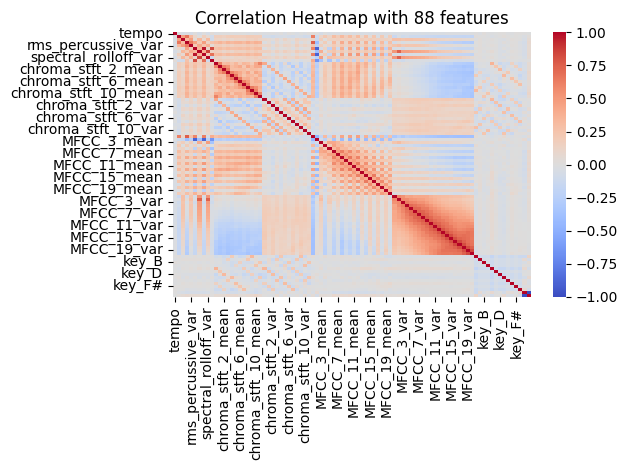

In [44]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming correlation_matrix1 and correlation_matrix2 are your correlation matrices
# axes = sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
# axes.set_title('Correlation Heatmap with 88 features')

# # Adjust layout to prevent overlapping titles
# plt.tight_layout()

# # Show the plots
# plt.show()

**Finding 1:**

Deep blue color: Indicates strong negative correlation, meaning an increase in one feature is accompanied by a decrease in another feature.Deep red color: Represents strong positive correlation, implying that an increase in one feature is associated with an increase in another feature.Light color (close to white): Indicates correlation close to zero, suggesting a relatively weak linear relationship between two features.
Low correlation: Mainly light color indicates a relatively weak linear relationship between features. In other words, changes in one music feature are not likely to significantly predict changes in another feature. It can be used to avoid features affected by multicollinearity.
Nonlinear relationships: The correlation heatmap primarily displays linear relationships. If there are nonlinear relationships between features, the correlation heatmap might not capture these relationships effectively.
The top 5 pairs of features with the strongest linear correlations.
1. Feature X: spectral_centroid_mean, Feature Y: spectral_rolloff_mean, Value: 0.967%
2. Feature X: spectral_centroid_mean, Feature Y: MFCC_2_mean, Value: -0.900%
3. Feature X: spectral_rolloff_mean, Feature Y: MFCC_2_mean, Value: -0.894%
4. Feature X: spectral_centroid_var, Feature Y: spectral_rolloff_var, Value: 0.867%
5. Feature X: MFCC_16_var, Feature Y: MFCC_17_var, Value: 0.834%


In [17]:
!pip install umap-learn==0.5.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.9 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76544 sha256=d0743c7111e49b31605d1d335b08c34c590f73f7247ca18ea94106e3ac96daf4
  Stored in directory: /root/.cache/pip/wheels/69/21/8e/802cb9c4c606a67139f538cb17bf3bf1b98b739a7900469953
Successfully built umap-learn


In [8]:
!pip install pynndescent==0.5.4

     |████████████████████████████████| 1.1 MB 7.5 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for pynndescent: filename=pynndescent-0.5.4-py3-none-any.whl size=52374 sha256=84a207c3842a9a5628cc9d7524ca8097223b23db3fa6724436fe0a2f1d8faa76
  Stored in directory: /Users/1108232/Library/Caches/pip/wheels/22/d3/c4/b9c26d3f7336f88188002b54b828c573b8bd4ee800bb5edc63
Successfully built pynndescent
You should consider upgrading via the '/Users/1108232/PycharmProjects/MADS-699-Capstone-fa23-team12/venv/bin/python -m pip install --upgrade pip' command.


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:646: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
<ipython-input-47-acbf6062cefa>:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(umap_result[:, 0], umap_result[:, 1], marker='o', s=1, cmap='viridis')


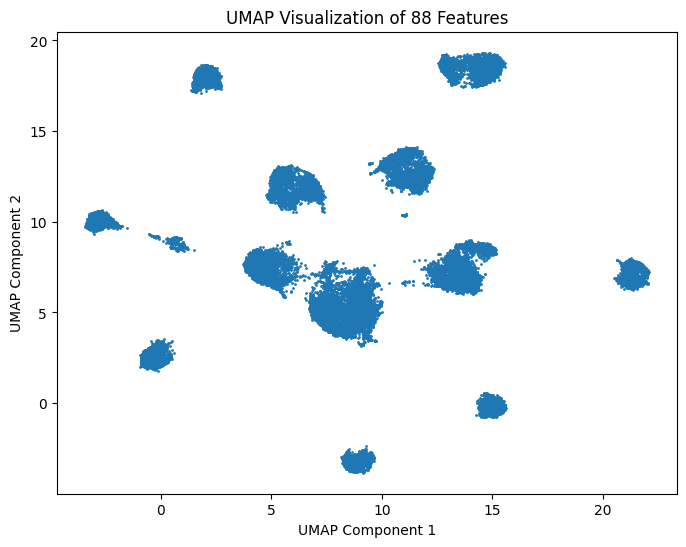

In [47]:
# import umap
# import matplotlib.pyplot as plt

# # Create a UMAP model with 2 dimensions
# umap_model = umap.UMAP(n_components=2, n_jobs=2, random_state=42)

# # Fit UMAP without tqdm progress bar
# umap_result = umap_model.fit_transform(get_normalize())

# # Create a 2D scatter plot
# plt.figure(figsize=(8, 6))
# plt.scatter(umap_result[:, 0], umap_result[:, 1], marker='o', s=1, cmap='viridis')

# # Add labels, titles, etc.
# plt.xlabel('UMAP Component 1')
# plt.ylabel('UMAP Component 2')
# plt.title('UMAP Visualization of 88 Features')

# # Show the 2D plot
# plt.show()

In [49]:
# from pycaret.clustering import *

# # Initialize clustering environment
# exp1 = setup(umap_result,session_id=123)

# # Create multiple clustering models
# models = ['kmeans', 'dbscan','hclust', 'birch']

# # Evaluate models and visualize clustering results
# for model in models:
#     # Create the clustering model
#     print("\033[94m"+"\033[1m"+model)
#     clustering_model = create_model(model,num_clusters=15)

,Description,Value
0,Session id,123
1,Original data shape,"(24772, 2)"
2,Transformed data shape,"(24772, 2)"
3,Numeric features,2
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,False


kmeans


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6875,165011.4278,0.4316,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

dbscan


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6807,66777.7708,0.3243,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

hclust


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6876,162825.8808,0.4150,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

birch


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6821,147497.6733,0.4075,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [50]:
!pip install scikit-learn==0.24.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 20.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


Best number of clusters: 15
Best Calinski-Harabasz score: 164999.46579572305
Best Davies-Bouldin score: 0.4341194928342485


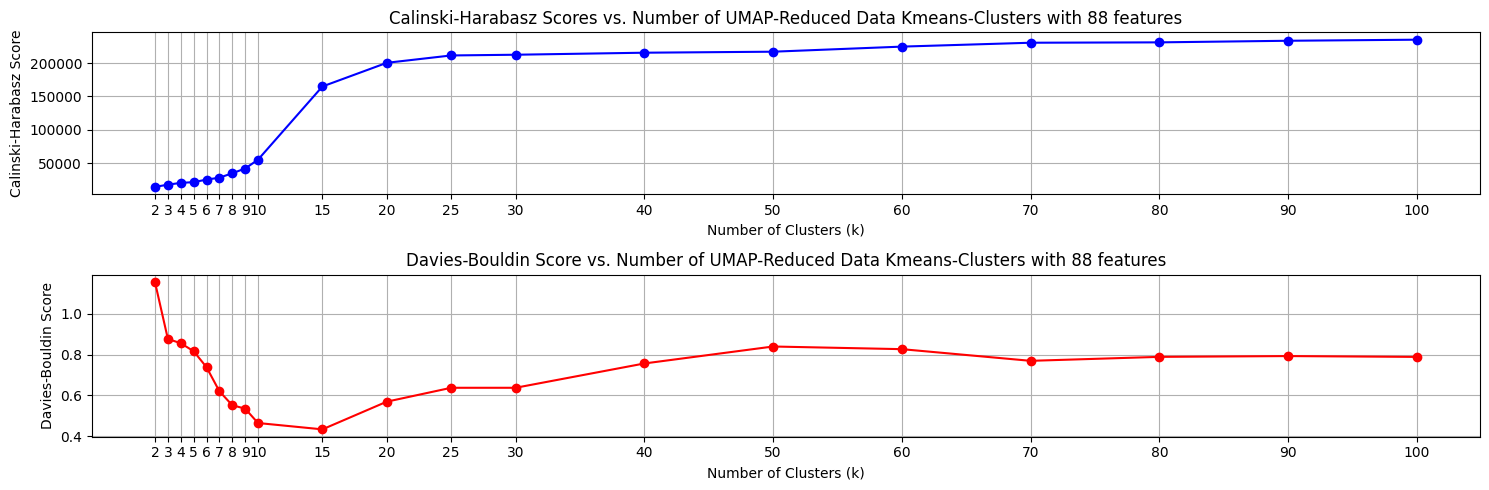

In [74]:
# from sklearn.cluster import KMeans
# from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# # Define a list of candidate cluster values
# k_values = [2,3,4,5,6,7,8,9, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]

# # Initialize variables for tracking the best clustering
# best_calinski_score = -1
# best_davies_bouldin_score = float("inf")
# best_k = None

# # Lists to store Calinski-Harabasz and Davies-Bouldin scores for each k
# calinski_scores_list = []
# davies_bouldin_scores_list = []

# # Iterate over different cluster values
# for k in k_values:
#     # Set a random seed for reproducibility
#     np.random.seed(42)

#     # Create a KMeans model with 'k' clusters
#     kmeans = KMeans(n_clusters=k, random_state=42)

#     # Fit the model and predict cluster labels on UMAP-reduced data
#     kmeans_labels = kmeans.fit_predict(umap_result)

#     # Calculate Calinski-Harabasz score
#     calinski_score = calinski_harabasz_score(umap_result, kmeans_labels)
#     calinski_scores_list.append(calinski_score)

#     # Calculate Davies-Bouldin score
#     davies_bouldin = davies_bouldin_score(umap_result, kmeans_labels)
#     davies_bouldin_scores_list.append(davies_bouldin)

#     # Update the best clustering if a better combination is found
#     if calinski_score > best_calinski_score and davies_bouldin < best_davies_bouldin_score:
#         best_calinski_score = calinski_score
#         best_davies_bouldin_score = davies_bouldin
#         best_k = k

# # Print the results of the best clustering
# print("\033[94m"+"\033[1m"+f"Best number of clusters: {best_k}")
# print("\033[94m"+"\033[1m"+f"Best Calinski-Harabasz score: {best_calinski_score}")
# print("\033[94m"+"\033[1m"+f"Best Davies-Bouldin score: {best_davies_bouldin_score}")

# # Create a figure for plotting
# plt.figure(figsize=(15, 5))

# # First subplot: Calinski-Harabasz Score
# plt.subplot(2, 1, 1)  # 2 rows, 1 column, subplot 1
# plt.plot(k_values, calinski_scores_list, marker='o', color='blue')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Calinski-Harabasz Score')
# plt.title('Calinski-Harabasz Scores vs. Number of UMAP-Reduced Data Kmeans-Clusters with 88 features')
# plt.grid(True)
# plt.xticks(k_values)

# # Second subplot: Davies-Bouldin Score
# plt.subplot(2, 1, 2)  # 2 rows, 1 column, subplot 2
# plt.plot(k_values, davies_bouldin_scores_list, marker='o', color='red')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Davies-Bouldin Score')
# plt.title('Davies-Bouldin Score vs. Number of UMAP-Reduced Data Kmeans-Clusters with 88 features')
# plt.grid(True)

# # Set x-axis tick positions to the values in k_values
# plt.xticks(k_values)

# # Adjust layout to prevent subplot overlap
# plt.tight_layout()
# plt.show()


In [53]:
# from sklearn.cluster import DBSCAN
# from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# eps_values = [0.1, 0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9]
# min_samples_values = [5,10, 15, 20]

# best_calinski_score = -1
# best_davies_bouldin_score = float("inf")
# best_eps = None
# best_min_samples = None

# for eps in eps_values:
#     for min_samples in min_samples_values:
#         dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#         dbscan_labels = dbscan.fit_predict(umap_result)

#         calinski = calinski_harabasz_score(umap_result, dbscan_labels)
#         davies_bouldin = davies_bouldin_score(umap_result, dbscan_labels)

#         if calinski > best_calinski_score and davies_bouldin < best_davies_bouldin_score:

#             best_calinski_score = calinski
#             best_davies_bouldin_score = davies_bouldin
#             best_eps = eps
#             best_min_samples = min_samples

# print("\033[94m"+"\033[1m"+"Best eps:", best_eps)
# print("\033[94m"+"\033[1m"+"Best min_samples:", best_min_samples)

# print("\033[94m"+"\033[1m"+"Best Calinski-Harabasz Score:", best_calinski_score)
# print("\033[94m"+"\033[1m"+"Best Davies-Bouldin Score:", best_davies_bouldin_score)


Best eps: 0.4
Best min_samples: 20
Best Calinski-Harabasz Score: 134864.98477722236
Best Davies-Bouldin Score: 0.46662299503646876


Number of cluster is: 13


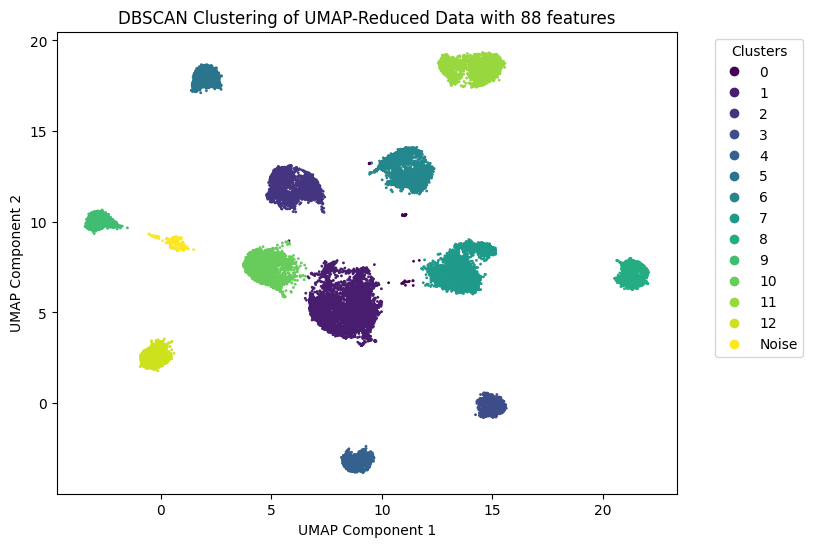

In [54]:
# from sklearn.cluster import DBSCAN
# import matplotlib.pyplot as plt

# dbscan = DBSCAN(eps=best_eps, min_samples= best_min_samples)

# dbscan_labels = dbscan.fit_predict(umap_result)

# # Calculate the number of clusters (excluding noise points)
# num_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
# print("\033[94m"+"\033[1m"+"Number of cluster is:",num_clusters)
# # Set colors for each cluster, including black for noise points
# colors = plt.cm.viridis(np.linspace(0, 1, num_clusters + 1))
# colors = np.vstack((colors, [0, 0, 0, 1]))  # Add black color for noise points

# # Plot the scatter plot
# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=dbscan_labels, cmap='viridis', s=1)

# # Add legend outside the plot
# legend_labels = list(range(num_clusters)) + ['Noise']
# legend_labels = [str(label) for label in legend_labels]
# plt.legend(handles=scatter.legend_elements()[0], title='Clusters', labels=legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')

# # Add axis labels and title
# plt.xlabel('UMAP Component 1')
# plt.ylabel('UMAP Component 2')
# plt.title('DBSCAN Clustering of UMAP-Reduced Data with 88 features')

# # Show the plot
# plt.show()

Secondly, Apply PCA to deduce the dimension

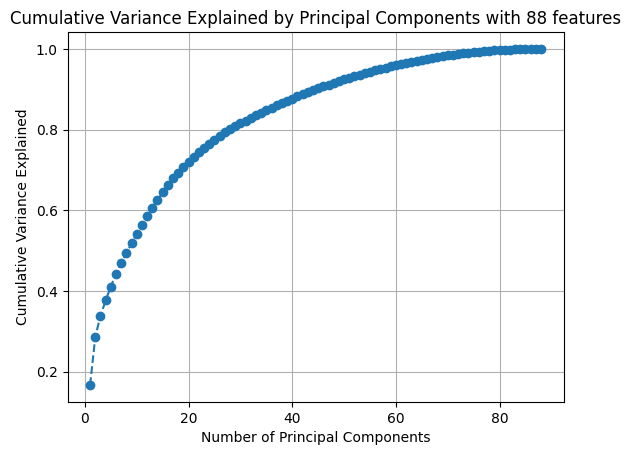

In [11]:
#it typically used to help determine how many principal components (dimensions) to retain in Principal Component Analysis (PCA).
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
pca=None
pca = PCA(random_state=42).fit(get_normalize())
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by Principal Components with 88 features')
plt.grid()
plt.show()

In [14]:
np.random.seed(42)
cumulative_variance_ratio = explained_variance_ratio.cumsum()
desired_variance_ratio = 0.8  #  set 80% as cumulative variance explained threshold
components_needed = np.where(cumulative_variance_ratio >= desired_variance_ratio)[0][0] + 1
components_needed
print("\033[94m"+"\033[1m"+"The components we need in PCA with 88 features:", components_needed)

The components we need in PCA with 88 features: 28


In [16]:
from sklearn.decomposition import PCA

np.random.seed(42)
pca = PCA(n_components=28,random_state=42)
pca_result = pca.fit_transform(get_normalize())

# get contribution from each PC
explained_variance_ratio = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_

# Calculate the variance of Principal Component 1 (PC1)
variance_pc1 = eigenvalues[0]

# Calculate the variance of Principal Component 2 (PC2)
variance_pc2 = eigenvalues[1]

# Calculate the variance of Principal Component 3 (PC3)
variance_pc3 = eigenvalues[2]

# Calculate the variance contribution ratio
total_variance = sum(eigenvalues)
variance_ratio_pc1 = variance_pc1 / total_variance
variance_ratio_pc2 = variance_pc2 / total_variance
variance_ratio_pc3 = variance_pc3 / total_variance

# Format the values with two decimal places
variance_pc1_formatted = "{:.2f}".format(variance_pc1)
variance_pc2_formatted = "{:.2f}".format(variance_pc2)
variance_pc3_formatted = "{:.2f}".format(variance_pc3)
variance_ratio_pc1_formatted = "{:.2f}".format(variance_ratio_pc1)
variance_ratio_pc2_formatted = "{:.2f}".format(variance_ratio_pc2)
variance_ratio_pc3_formatted = "{:.2f}".format(variance_ratio_pc3)


print("Variance of PC1:", variance_pc1_formatted)
print("Variance of PC2:", variance_pc2_formatted)
print("Variance of PC3:", variance_pc3_formatted)
print("Variance Ratio of PC1:", variance_ratio_pc1_formatted)
print("Variance Ratio of PC2:", variance_ratio_pc2_formatted)
print("Variance Ratio of PC3:", variance_ratio_pc3_formatted)
print("\033[94m"+"\033[1m"+"Variance Ratio of PC1,PC2,PC3 with 88 features:", float(variance_ratio_pc1_formatted)+float(variance_ratio_pc2_formatted)+float(variance_ratio_pc3_formatted))

Variance of PC1: 14.72
Variance of PC2: 10.49
Variance of PC3: 4.59
Variance Ratio of PC1: 0.21
Variance Ratio of PC2: 0.15
Variance Ratio of PC3: 0.07
Variance Ratio of PC1,PC2,PC3 with 88 features: 0.43


To run KMeans cluster on PCA Reduced Data

Best number of clusters: 5
Best Calinski-Harabasz score: 1945.0807510184657
Best Davies-Bouldin score: 2.792245421921951


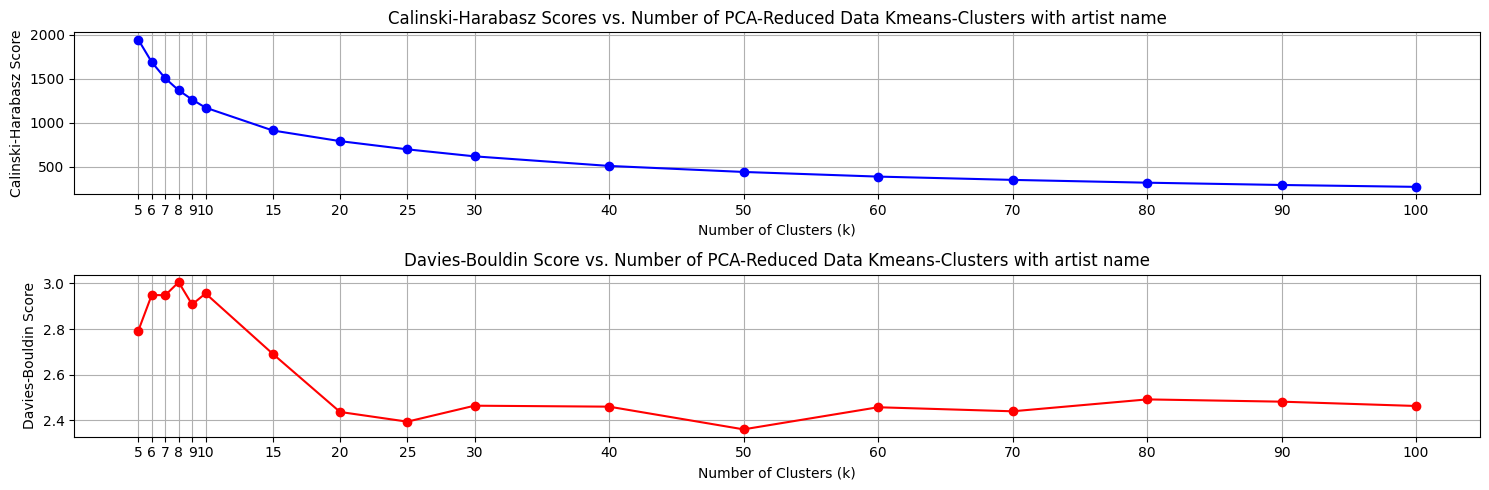

In [78]:
# import numpy as np
# import umap
# from sklearn.cluster import KMeans
# from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score


# np.random.seed(42)
# pca = PCA(n_components=components_needed,random_state=42)
# pca_result = pca.fit_transform(get_normalize())

# k_values = [5, 6,7,8,9,10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]

# best_calinski_score = -1
# best_davies_bouldin_score = float("inf")

# best_k = None
# calinski_scores_list = []
# davies_bouldin_scores_list = []

# for k in k_values:
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans_labels = kmeans.fit_predict(pca_result)

#     calinski_score = calinski_harabasz_score(pca_result, kmeans_labels)
#     calinski_scores_list.append(calinski_score)

#     davies_bouldin = davies_bouldin_score(pca_result, kmeans_labels)
#     davies_bouldin_scores_list.append(davies_bouldin)

#     if calinski_score > best_calinski_score and davies_bouldin < best_davies_bouldin_score:
#         best_calinski_score = calinski_score
#         best_davies_bouldin_score = davies_bouldin
#         best_k = k

# print("\033[94m"+"\033[1m"+f"Best number of clusters: {best_k}")
# print("\033[94m"+"\033[1m"+f"Best Calinski-Harabasz score: {best_calinski_score}")
# print("\033[94m"+"\033[1m"+f"Best Davies-Bouldin score: {best_davies_bouldin_score}")

# plt.figure(figsize=(15, 5))

# # subplot1：Calinski-Harabasz Score
# plt.subplot(2, 1, 1)
# plt.plot(k_values, calinski_scores_list, marker='o', color='blue')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Calinski-Harabasz Score')
# plt.title('Calinski-Harabasz Scores vs. Number of PCA-Reduced Data Kmeans-Clusters with artist name')
# plt.grid(True)
# plt.xticks(k_values)

# # subplot2：Davies-Bouldin Score
# plt.subplot(2, 1, 2)
# plt.plot(k_values, davies_bouldin_scores_list, marker='o', color='red')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Davies-Bouldin Score')
# plt.title('Davies-Bouldin Score vs. Number of PCA-Reduced Data Kmeans-Clusters with artist name')
# plt.grid(True)
# plt.xticks(k_values)
# plt.tight_layout()
# plt.show()


**Finding 2:**

- This may indicate that the dataset contains complex nonlinear relationships. UMAP is more proficient at capturing these nonlinear relationships during dimensionality reduction, making it more effective to use linear clustering methods on nonlinear data.PCA is primarily designed to capture linear relationships, and as a result, it may perform poorly in clustering tasks with complex nonlinear structures.

Create a UMAP model base on PCA reduced data with 2 dimensions

<ipython-input-25-52b035d726d4>:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(umap_pca_result[:, 0],umap_pca_result[:, 1], marker='o', s=1, cmap='viridis')


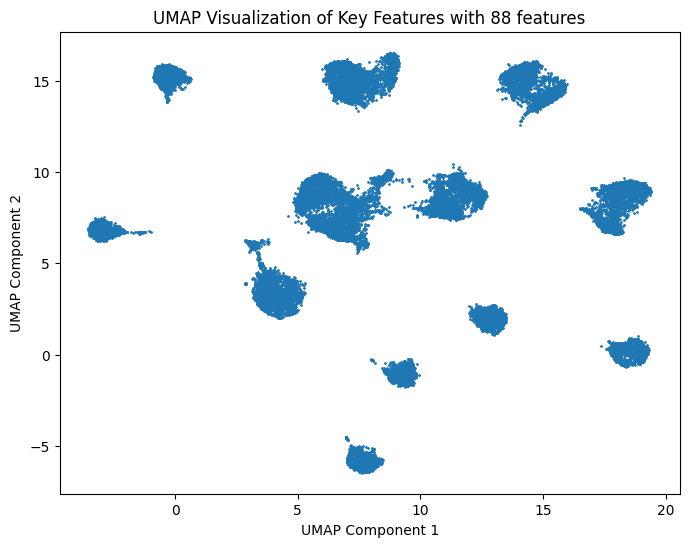

In [25]:
import umap
umap_model = umap.UMAP(n_components=2, n_jobs=2, random_state=42)

# Use fit_transform to reduce the dimensionality of data in key_feature_df to 2 dimensions
umap_pca_result = umap_model.fit_transform(pca_result)

# Create a 2D scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(umap_pca_result[:, 0],umap_pca_result[:, 1], marker='o', s=1, cmap='viridis')

# Add labels, titles, etc.
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Visualization of Key Features with 88 features')

# Show the 2D plot
plt.show()

KMeans model based on UMAP and PCA

Best number of clusters: 15
Best Calinski-Harabasz score: 159694.43879571822
Best Davies-Bouldin score: 0.3733627620912832


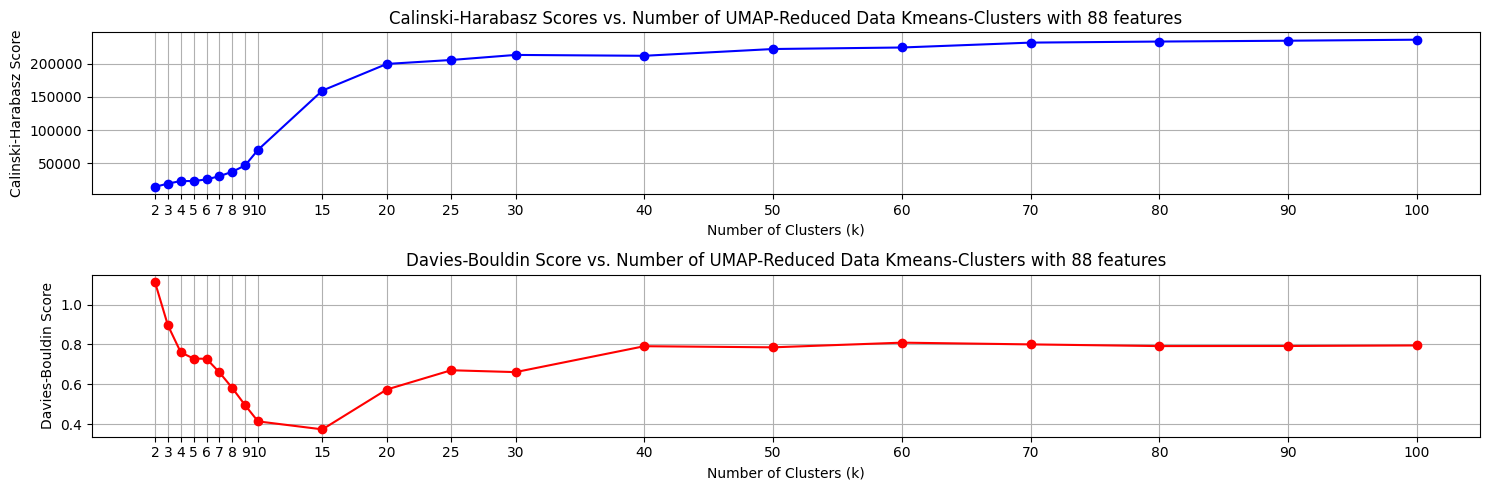

In [80]:
# k_values = [2,3,4,5,6,7,8,9,10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]

# best_calinski_score = -1
# best_davies_bouldin_score = float("inf")

# best_k = None
# calinski_scores_list = []
# davies_bouldin_scores_list = []

# for k in k_values:
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans_labels = kmeans.fit_predict(umap_pca_result)

#     calinski_score = calinski_harabasz_score(umap_pca_result, kmeans_labels)
#     calinski_scores_list.append(calinski_score)

#     davies_bouldin = davies_bouldin_score(umap_pca_result, kmeans_labels)
#     davies_bouldin_scores_list.append(davies_bouldin)

#     if calinski_score > best_calinski_score and davies_bouldin < best_davies_bouldin_score:
#         best_calinski_score = calinski_score
#         best_davies_bouldin_score = davies_bouldin
#         best_k = k

# print("\033[94m"+"\033[1m"+f"Best number of clusters: {best_k}")
# print("\033[94m"+"\033[1m"+f"Best Calinski-Harabasz score: {best_calinski_score}")
# print("\033[94m"+"\033[1m"+f"Best Davies-Bouldin score: {best_davies_bouldin_score}")


# plt.figure(figsize=(15, 5))

# # Calinski-Harabasz Score
# plt.subplot(2, 1, 1)
# plt.plot(k_values, calinski_scores_list, marker='o', color='blue')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Calinski-Harabasz Score')
# plt.title('Calinski-Harabasz Scores vs. Number of UMAP-Reduced Data Kmeans-Clusters with 88 features')
# plt.grid(True)
# plt.xticks(k_values)

# # Davies-Bouldin Score
# plt.subplot(2, 1, 2)
# plt.plot(k_values, davies_bouldin_scores_list, marker='o', color='red')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Davies-Bouldin Score')
# plt.title('Davies-Bouldin Score vs. Number of UMAP-Reduced Data Kmeans-Clusters with 88 features')
# plt.grid(True)

# plt.xticks(k_values)

# plt.tight_layout()  # ensure subplot not overlap
# plt.show()



In [26]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

eps_values = [0.1, 0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9]
min_samples_values = [5,10, 15, 20]

best_calinski_score = -1
best_davies_bouldin_score = float("inf")
best_eps = None
best_min_samples = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(umap_pca_result)

        calinski = calinski_harabasz_score(umap_pca_result, dbscan_labels)
        davies_bouldin = davies_bouldin_score(umap_pca_result, dbscan_labels)

        if calinski > best_calinski_score and davies_bouldin < best_davies_bouldin_score:

            best_calinski_score = calinski
            best_davies_bouldin_score = davies_bouldin
            best_eps = eps
            best_min_samples = min_samples

print("\033[94m"+"\033[1m"+"Best eps:", best_eps)
print("\033[94m"+"\033[1m"+"Best min_samples:", best_min_samples)

print("\033[94m"+"\033[1m"+"Best Calinski-Harabasz Score:", best_calinski_score)
print("\033[94m"+"\033[1m"+"Best Davies-Bouldin Score:", best_davies_bouldin_score)

Best eps: 0.4
Best min_samples: 5
Best Calinski-Harabasz Score: 139197.55788357896
Best Davies-Bouldin Score: 0.2822181234923136


Number of cluster is: 12


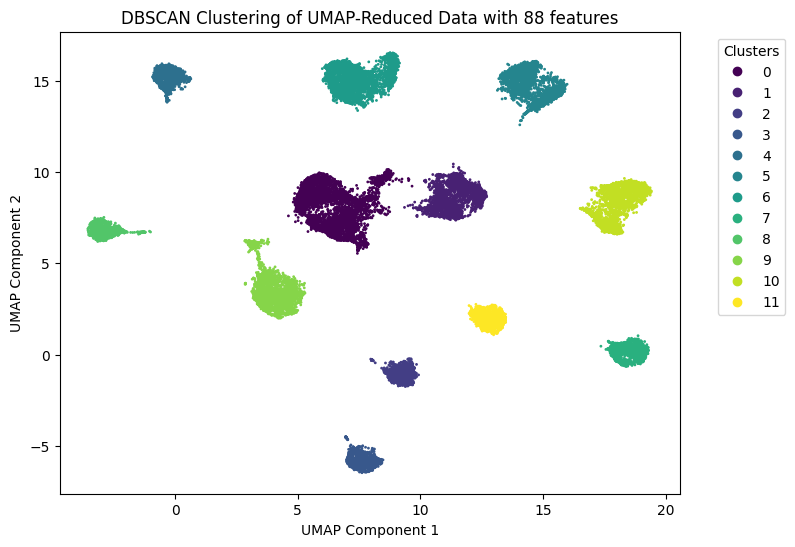

In [29]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

dbscan = DBSCAN(eps=0.4, min_samples= 5)

dbscan_labels = dbscan.fit_predict(umap_pca_result)

# Calculate the number of clusters (excluding noise points)
num_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print("\033[94m"+"\033[1m"+"Number of cluster is:",num_clusters)
# Set colors for each cluster, including black for noise points
colors = plt.cm.viridis(np.linspace(0, 1, num_clusters + 1))
colors = np.vstack((colors, [0, 0, 0, 1]))  # Add black color for noise points

# Plot the scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(umap_pca_result[:, 0], umap_pca_result[:, 1], c=dbscan_labels, cmap='viridis', s=1)

# Add legend outside the plot
legend_labels = list(range(num_clusters)) + ['Noise']
legend_labels = [str(label) for label in legend_labels]
plt.legend(handles=scatter.legend_elements()[0], title='Clusters', labels=legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')

# Add axis labels and title
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('DBSCAN Clustering of UMAP-Reduced Data with 88 features')

# Show the plot
plt.show()

**Finding 3:**

In [61]:
from pycaret.clustering import *

# Initialize clustering environment
exp1 = setup(umap_pca_result,session_id=123)

# Create multiple clustering models
models = ['kmeans', 'dbscan','hclust', 'birch']

# Evaluate models and visualize clustering results
for model in models:
    # Create the clustering model
    print("\033[94m"+"\033[1m"+model)
    clustering_model = create_model(model,num_clusters=15)

,Description,Value
0,Session id,123
1,Original data shape,"(24772, 2)"
2,Transformed data shape,"(24772, 2)"
3,Numeric features,2
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,False


kmeans


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7002,163369.1692,0.4195,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

dbscan


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7745,139197.5573,0.2822,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

hclust


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6874,156734.6636,0.4214,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

birch


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7158,152073.3693,0.3501,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [62]:
kmeans_umap = KMeans(n_clusters=15, random_state=42)
kmeans_umap_labels = kmeans_umap.fit_predict(umap_result)

grouped_umap_15_88feature_df = grouped_df_88.copy()
grouped_umap_15_88feature_df['KMeans_umap_Labels'] = kmeans_umap_labels

grouped_umap_15_88feature_df.to_csv('grouped_umap_15_88feature_df.csv',index=True)
grouped_umap_15_88feature_df['KMeans_umap_Labels'].value_counts()



3     2970
2     2641
8     2549
4     2488
1     2195
0     2187
14    1697
6     1317
7     1193
9     1139
11    1036
13    1014
5     1011
10     968
12     367
Name: KMeans_umap_Labels, dtype: int64

In [32]:
dbscan = DBSCAN(eps=0.4, min_samples=5)

dbscan_labels = dbscan.fit_predict(umap_pca_result)

grouped_dbscan_12_88feature_df = grouped_df_88.copy()
grouped_dbscan_12_88feature_df['dbscan_umap_pca_Labels'] = dbscan_labels

grouped_dbscan_12_88feature_df.to_csv('grouped_dbscan_12_88feature_df.csv',index=True)
grouped_dbscan_12_88feature_df['dbscan_umap_pca_Labels'].value_counts()

0     4563
6     3204
5     2635
10    2608
1     2506
9     2409
7     1329
11    1198
4     1176
2     1075
3     1045
8     1024
Name: dbscan_umap_pca_Labels, dtype: int64

In [33]:
grouped_dbscan_12_88feature_df

,tempo,rms_harmonic_mean,rms_harmonic_var,rms_percussive_mean,rms_percussive_var,spectral_centroid_mean,spectral_centroid_var,spectral_rolloff_mean,spectral_rolloff_var,zero_crossings,...,key_C#,key_D,key_E,key_Eb,key_F,key_F#,key_G,scale_major,scale_minor,dbscan_umap_pca_Labels
track_id,,,,,,,,,,,,,,,,,,,,,
2,161.499023,0.060801,0.000606,0.102429,0.006546,2975.279504,9.329318e+05,6088.350559,2.180362e+06,107473.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,86.132812,0.068484,0.001239,0.065604,0.002172,2758.702053,7.728350e+05,5681.876212,2.165383e+06,97557.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1
5,99.384014,0.079553,0.002230,0.085417,0.003846,2361.216888,7.092386e+05,5326.953068,2.415460e+06,65573.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2
10,112.347147,0.135624,0.000600,0.081036,0.003281,2319.325849,1.273302e+05,4256.393704,5.828485e+05,98089.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3
134,135.999178,0.088261,0.001123,0.094477,0.003812,2378.782197,8.972040e+05,4994.820480,3.289453e+06,75757.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155297,123.046875,0.038447,0.000094,0.009430,0.000010,1086.737344,2.616489e+04,2075.452180,2.233537e+05,25977.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5
155298,129.199219,0.139233,0.003167,0.034027,0.000692,1298.012055,2.025990e+05,2638.849911,1.528219e+06,27670.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1
155306,103.359375,0.116513,0.003872,0.020412,0.000516,981.610925,2.969271e+05,1911.859883,1.796457e+06,27141.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4


In [63]:
# grouped_umap_15_88feature_df

,tempo,rms_harmonic_mean,rms_harmonic_var,rms_percussive_mean,rms_percussive_var,spectral_centroid_mean,spectral_centroid_var,spectral_rolloff_mean,spectral_rolloff_var,zero_crossings,chroma_stft_0_mean,chroma_stft_1_mean,chroma_stft_2_mean,chroma_stft_3_mean,chroma_stft_4_mean,chroma_stft_5_mean,chroma_stft_6_mean,chroma_stft_7_mean,chroma_stft_8_mean,chroma_stft_9_mean,chroma_stft_10_mean,chroma_stft_11_mean,chroma_stft_0_var,chroma_stft_1_var,chroma_stft_2_var,chroma_stft_3_var,chroma_stft_4_var,chroma_stft_5_var,chroma_stft_6_var,chroma_stft_7_var,chroma_stft_8_var,chroma_stft_9_var,chroma_stft_10_var,chroma_stft_11_var,MFCC_1_mean,MFCC_2_mean,MFCC_3_mean,MFCC_4_mean,MFCC_5_mean,MFCC_6_mean,MFCC_7_mean,MFCC_8_mean,MFCC_9_mean,MFCC_10_mean,MFCC_11_mean,MFCC_12_mean,MFCC_13_mean,MFCC_14_mean,MFCC_15_mean,MFCC_16_mean,MFCC_17_mean,MFCC_18_mean,MFCC_19_mean,MFCC_20_mean,MFCC_1_var,MFCC_2_var,MFCC_3_var,MFCC_4_var,MFCC_5_var,MFCC_6_var,MFCC_7_var,MFCC_8_var,MFCC_9_var,MFCC_10_var,MFCC_11_var,MFCC_12_var,MFCC_13_var,MFCC_14_var,MFCC_15_var,MFCC_16_var,MFCC_17_var,MFCC_18_var,MFCC_19_var,MFCC_20_var,key_A,key_Ab,key_B,key_Bb,key_C,key_C#,key_D,key_E,key_Eb,key_F,key_F#,key_G,scale_major,scale_minor,KMeans_umap_Labels
track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,161.50,0.06,6.06e-04,1.02e-01,6.55e-03,2975.28,9.33e+05,6088.35,2.18e+06,107473.0,0.75,0.47,0.38,0.34,0.27,0.23,0.27,0.42,0.37,0.36,0.38,0.52,0.09,0.07,0.08,0.07,0.05,0.05,0.05,0.08,0.07,0.08,0.07,0.08,-70.15,69.02,-14.53,16.02,-7.12,13.70,-5.73,9.11,-9.80,4.67,-13.84,6.85,-6.38,11.47,-6.50,4.35,-11.48,0.86,-5.74,2.78,2871.07,904.36,497.49,303.56,297.35,195.98,161.33,94.82,103.84,78.13,87.05,114.95,75.48,65.71,53.54,50.61,53.58,53.73,53.25,41.47,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3
3,86.13,0.07,1.24e-03,6.56e-02,2.17e-03,2758.70,7.73e+05,5681.88,2.17e+06,97557.0,0.39,0.35,0.46,0.43,0.29,0.27,0.36,0.58,0.45,0.46,0.48,0.40,0.10,0.08,0.10,0.09,0.05,0.05,0.05,0.10,0.09,0.08,0.09,0.07,-100.49,76.35,-7.42,33.50,1.76,15.90,-7.72,10.34,-11.46,10.42,-10.05,3.75,-6.79,3.91,-7.26,3.99,-5.89,4.87,-11.69,0.07,5272.30,715.41,500.04,206.93,281.07,119.93,91.65,129.79,88.12,134.15,51.89,64.37,69.20,68.99,61.59,52.91,64.76,48.98,51.46,43.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,4
5,99.38,0.08,2.23e-03,8.54e-02,3.85e-03,2361.22,7.09e+05,5326.95,2.42e+06,65573.0,0.41,0.58,0.40,0.34,0.32,0.33,0.37,0.40,0.49,0.49,0.51,0.46,0.07,0.11,0.07,0.07,0.07,0.07,0.08,0.08,0.11,0.11,0.10,0.10,-108.92,90.48,8.92,27.36,-4.16,15.99,-8.66,20.45,-9.26,2.88,-4.72,11.69,0.69,9.96,-2.35,3.41,-6.52,1.72,-3.80,3.44,2168.54,809.52,447.10,305.37,278.10,186.81,137.73,102.25,94.64,102.07,98.11,72.86,89.89,56.42,56.53,66.61,45.47,44.91,65.22,65.56,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,11
10,112.35,0.14,6.00e-04,8.10e-02,3.28e-03,2319.33,1.27e+05,4256.39,5.83e+05,98089.0,0.28,0.65,0.33,0.35,0.23,0.32,0.70,0.34,0.38,0.31,0.57,0.31,0.03,0.09,0.03,0.07,0.02,0.03,0.08,0.03,0.07,0.04,0.08,0.04,-19.84,97.89,-52.09,35.82,-7.98,5.59,-5.64,5.96,-8.54,3.70,-12.37,5.30,-9.40,5.57,-7.90,1.83,-5.83,5.58,-3.47,6.20,790.14,384.33,275.08,118.67,110.01,56.61,60.81,57.73,54.42,46.33,43.03,35.31,33.09,31.83,31.38,46.40,32.05,46.06,31.41,32.89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5
134,136.00,0.09,1.12e-03,9.45e-02,3.81e-03,2378.78,8.97e+05,4994.82,3.29e+06,75757.0,0.42,0.45,0.52,0.44,0.54,0.49,0.44,0.46,0.48,0.54,0.51,0.42,0.07,0.07,0.10,0.07,0.09,0.08,0.06,0.08,0.08,0.08,0.09,0.08,-86.33,87.36,-5.28,37.42,1.97,11.28,1.15,22.65,-1.93,13.53,-0.18,10.93,-0.11,5.38,-6.58,2.91,-6.09,5.77,-4.72,-1.28,1494.90,1137.11,500.66,401.99,371.58,178.74,178.22,132.99,117.34,93.38,74.75,65.04,55.83,49.83,56.15,53.38,54.34,44.79,42.40,43.05,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [37]:
merged_df_dbscan = pd.merge(grouped_dbscan_12_88feature_df, tracks_features_and_labels_all_df[['track_id', 'track_genre_top']], on='track_id', how='left')

# Create a new 'target' column and fill it with 'track_genre_top' values
merged_df_dbscan['target'] = merged_df_dbscan['track_genre_top']

In [38]:
merged_df_dbscan = merged_df_dbscan.drop('track_genre_top', axis=1)

merged_df_with_dbscan_umap_Labels = merged_df_dbscan.drop('track_id',axis=1)
# merged_df_with_KMeans_umap_Labels_without_keyscale = merged_df.drop(['track_id', 'key_A', 'key_Ab', 'key_B', 'key_Bb',
#        'key_C', 'key_C#', 'key_D', 'key_E', 'key_Eb', 'key_F', 'key_F#',
#        'key_G', 'scale_major', 'scale_minor'],axis=1)
display(merged_df_with_dbscan_umap_Labels)

merged_df_no_dbscan_umap_Labels = merged_df_with_dbscan_umap_Labels.drop('dbscan_umap_pca_Labels',axis=1)
# merged_df_no_KMeans_umap_Labels_without_keyscale = merged_df.drop(['track_id', 'key_A', 'key_Ab', 'key_B', 'key_Bb',
#        'key_C', 'key_C#', 'key_D', 'key_E', 'key_Eb', 'key_F', 'key_F#',
#        'key_G', 'scale_major', 'scale_minor','KMeans_umap_Labels'],axis=1)
merged_df_no_dbscan_umap_Labels

,tempo,rms_harmonic_mean,rms_harmonic_var,rms_percussive_mean,rms_percussive_var,spectral_centroid_mean,spectral_centroid_var,spectral_rolloff_mean,spectral_rolloff_var,zero_crossings,...,key_D,key_E,key_Eb,key_F,key_F#,key_G,scale_major,scale_minor,dbscan_umap_pca_Labels,target
0,161.499023,0.060801,0.000606,0.102429,0.006546,2975.279504,9.329318e+05,6088.350559,2.180362e+06,107473.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,Hip-Hop
1,86.132812,0.068484,0.001239,0.065604,0.002172,2758.702053,7.728350e+05,5681.876212,2.165383e+06,97557.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,Hip-Hop
2,99.384014,0.079553,0.002230,0.085417,0.003846,2361.216888,7.092386e+05,5326.953068,2.415460e+06,65573.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2,Hip-Hop
3,112.347147,0.135624,0.000600,0.081036,0.003281,2319.325849,1.273302e+05,4256.393704,5.828485e+05,98089.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3,Pop
4,135.999178,0.088261,0.001123,0.094477,0.003812,2378.782197,8.972040e+05,4994.820480,3.289453e+06,75757.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4,Hip-Hop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24767,123.046875,0.038447,0.000094,0.009430,0.000010,1086.737344,2.616489e+04,2075.452180,2.233537e+05,25977.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5,Instrumental
24768,129.199219,0.139233,0.003167,0.034027,0.000692,1298.012055,2.025990e+05,2638.849911,1.528219e+06,27670.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1,Folk
24769,103.359375,0.116513,0.003872,0.020412,0.000516,981.610925,2.969271e+05,1911.859883,1.796457e+06,27141.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4,Folk
24770,117.453835,0.085435,0.001713,0.038334,0.001488,2382.701436,1.676199e+06,5018.760139,6.796065e+06,68565.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,Experimental


,tempo,rms_harmonic_mean,rms_harmonic_var,rms_percussive_mean,rms_percussive_var,spectral_centroid_mean,spectral_centroid_var,spectral_rolloff_mean,spectral_rolloff_var,zero_crossings,...,key_C#,key_D,key_E,key_Eb,key_F,key_F#,key_G,scale_major,scale_minor,target
0,161.499023,0.060801,0.000606,0.102429,0.006546,2975.279504,9.329318e+05,6088.350559,2.180362e+06,107473.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Hip-Hop
1,86.132812,0.068484,0.001239,0.065604,0.002172,2758.702053,7.728350e+05,5681.876212,2.165383e+06,97557.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,Hip-Hop
2,99.384014,0.079553,0.002230,0.085417,0.003846,2361.216888,7.092386e+05,5326.953068,2.415460e+06,65573.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Hip-Hop
3,112.347147,0.135624,0.000600,0.081036,0.003281,2319.325849,1.273302e+05,4256.393704,5.828485e+05,98089.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Pop
4,135.999178,0.088261,0.001123,0.094477,0.003812,2378.782197,8.972040e+05,4994.820480,3.289453e+06,75757.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Hip-Hop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24767,123.046875,0.038447,0.000094,0.009430,0.000010,1086.737344,2.616489e+04,2075.452180,2.233537e+05,25977.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Instrumental
24768,129.199219,0.139233,0.003167,0.034027,0.000692,1298.012055,2.025990e+05,2638.849911,1.528219e+06,27670.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,Folk
24769,103.359375,0.116513,0.003872,0.020412,0.000516,981.610925,2.969271e+05,1911.859883,1.796457e+06,27141.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Folk
24770,117.453835,0.085435,0.001713,0.038334,0.001488,2382.701436,1.676199e+06,5018.760139,6.796065e+06,68565.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Experimental


In [64]:
# merged_df = pd.merge(grouped_umap_15_88feature_df, tracks_features_and_labels_all_df[['track_id', 'track_genre_top']], on='track_id', how='left')

# # Create a new 'target' column and fill it with 'track_genre_top' values
# merged_df['target'] = merged_df['track_genre_top']



# # Drop the redundant 'track_genre_top' column
# merged_df = merged_df.drop('track_genre_top', axis=1)

# merged_df_with_KMeans_umap_Labels = merged_df.drop('track_id',axis=1)
# merged_df_with_KMeans_umap_Labels_without_keyscale = merged_df.drop(['track_id', 'key_A', 'key_Ab', 'key_B', 'key_Bb',
#        'key_C', 'key_C#', 'key_D', 'key_E', 'key_Eb', 'key_F', 'key_F#',
#        'key_G', 'scale_major', 'scale_minor'],axis=1)
# display(merged_df_with_KMeans_umap_Labels)
# merged_df_no_KMeans_umap_Labels = merged_df_with_KMeans_umap_Labels.drop('KMeans_umap_Labels',axis=1)
# merged_df_no_KMeans_umap_Labels_without_keyscale = merged_df.drop(['track_id', 'key_A', 'key_Ab', 'key_B', 'key_Bb',
#        'key_C', 'key_C#', 'key_D', 'key_E', 'key_Eb', 'key_F', 'key_F#',
#        'key_G', 'scale_major', 'scale_minor','KMeans_umap_Labels'],axis=1)
# merged_df_no_KMeans_umap_Labels

,tempo,rms_harmonic_mean,rms_harmonic_var,rms_percussive_mean,rms_percussive_var,spectral_centroid_mean,spectral_centroid_var,spectral_rolloff_mean,spectral_rolloff_var,zero_crossings,chroma_stft_0_mean,chroma_stft_1_mean,chroma_stft_2_mean,chroma_stft_3_mean,chroma_stft_4_mean,chroma_stft_5_mean,chroma_stft_6_mean,chroma_stft_7_mean,chroma_stft_8_mean,chroma_stft_9_mean,chroma_stft_10_mean,chroma_stft_11_mean,chroma_stft_0_var,chroma_stft_1_var,chroma_stft_2_var,chroma_stft_3_var,chroma_stft_4_var,chroma_stft_5_var,chroma_stft_6_var,chroma_stft_7_var,chroma_stft_8_var,chroma_stft_9_var,chroma_stft_10_var,chroma_stft_11_var,MFCC_1_mean,MFCC_2_mean,MFCC_3_mean,MFCC_4_mean,MFCC_5_mean,MFCC_6_mean,MFCC_7_mean,MFCC_8_mean,MFCC_9_mean,MFCC_10_mean,MFCC_11_mean,MFCC_12_mean,MFCC_13_mean,MFCC_14_mean,MFCC_15_mean,MFCC_16_mean,MFCC_17_mean,MFCC_18_mean,MFCC_19_mean,MFCC_20_mean,MFCC_1_var,MFCC_2_var,MFCC_3_var,MFCC_4_var,MFCC_5_var,MFCC_6_var,MFCC_7_var,MFCC_8_var,MFCC_9_var,MFCC_10_var,MFCC_11_var,MFCC_12_var,MFCC_13_var,MFCC_14_var,MFCC_15_var,MFCC_16_var,MFCC_17_var,MFCC_18_var,MFCC_19_var,MFCC_20_var,key_A,key_Ab,key_B,key_Bb,key_C,key_C#,key_D,key_E,key_Eb,key_F,key_F#,key_G,scale_major,scale_minor,KMeans_umap_Labels,target
0,161.50,0.06,6.06e-04,1.02e-01,6.55e-03,2975.28,9.33e+05,6088.35,2.18e+06,107473.0,0.75,0.47,0.38,0.34,0.27,0.23,0.27,0.42,0.37,0.36,0.38,0.52,0.09,0.07,0.08,0.07,0.05,0.05,0.05,0.08,0.07,0.08,0.07,0.08,-70.15,69.02,-14.53,16.02,-7.12,13.70,-5.73,9.11,-9.80,4.67,-13.84,6.85,-6.38,11.47,-6.50,4.35,-11.48,0.86,-5.74,2.78,2871.07,904.36,497.49,303.56,297.35,195.98,161.33,94.82,103.84,78.13,87.05,114.95,75.48,65.71,53.54,50.61,53.58,53.73,53.25,41.47,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3,Hip-Hop
1,86.13,0.07,1.24e-03,6.56e-02,2.17e-03,2758.70,7.73e+05,5681.88,2.17e+06,97557.0,0.39,0.35,0.46,0.43,0.29,0.27,0.36,0.58,0.45,0.46,0.48,0.40,0.10,0.08,0.10,0.09,0.05,0.05,0.05,0.10,0.09,0.08,0.09,0.07,-100.49,76.35,-7.42,33.50,1.76,15.90,-7.72,10.34,-11.46,10.42,-10.05,3.75,-6.79,3.91,-7.26,3.99,-5.89,4.87,-11.69,0.07,5272.30,715.41,500.04,206.93,281.07,119.93,91.65,129.79,88.12,134.15,51.89,64.37,69.20,68.99,61.59,52.91,64.76,48.98,51.46,43.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,4,Hip-Hop
2,99.38,0.08,2.23e-03,8.54e-02,3.85e-03,2361.22,7.09e+05,5326.95,2.42e+06,65573.0,0.41,0.58,0.40,0.34,0.32,0.33,0.37,0.40,0.49,0.49,0.51,0.46,0.07,0.11,0.07,0.07,0.07,0.07,0.08,0.08,0.11,0.11,0.10,0.10,-108.92,90.48,8.92,27.36,-4.16,15.99,-8.66,20.45,-9.26,2.88,-4.72,11.69,0.69,9.96,-2.35,3.41,-6.52,1.72,-3.80,3.44,2168.54,809.52,447.10,305.37,278.10,186.81,137.73,102.25,94.64,102.07,98.11,72.86,89.89,56.42,56.53,66.61,45.47,44.91,65.22,65.56,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,11,Hip-Hop
3,112.35,0.14,6.00e-04,8.10e-02,3.28e-03,2319.33,1.27e+05,4256.39,5.83e+05,98089.0,0.28,0.65,0.33,0.35,0.23,0.32,0.70,0.34,0.38,0.31,0.57,0.31,0.03,0.09,0.03,0.07,0.02,0.03,0.08,0.03,0.07,0.04,0.08,0.04,-19.84,97.89,-52.09,35.82,-7.98,5.59,-5.64,5.96,-8.54,3.70,-12.37,5.30,-9.40,5.57,-7.90,1.83,-5.83,5.58,-3.47,6.20,790.14,384.33,275.08,118.67,110.01,56.61,60.81,57.73,54.42,46.33,43.03,35.31,33.09,31.83,31.38,46.40,32.05,46.06,31.41,32.89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5,Pop
4,136.00,0.09,1.12e-03,9.45e-02,3.81e-03,2378.78,8.97e+05,4994.82,3.29e+06,75757.0,0.42,0.45,0.52,0.44,0.54,0.49,0.44,0.46,0.48,0.54,0.51,0.42,0.07,0.07,0.10,0.07,0.09,0.08,0.06,0.08,0.08,0.08,0.09,0.08,-86.33,87.36,-5.28,37.42,1.97,11.28,1.15,22.65,-1.93,13.53,-0.18,10.93,-0.11,5.38,-6.58,2.91,-6.09,5.77,-4.72,-1.28,1494.90,1137.11,500.66,401.99,371.58,178.74,178.22,132.99,117.34,93.38,74.75,65.04,55.83,49.83,56.15,53.38,54.34,44.79,42.40,43.05,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9,Hip-Hop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

,tempo,rms_harmonic_mean,rms_harmonic_var,rms_percussive_mean,rms_percussive_var,spectral_centroid_mean,spectral_centroid_var,spectral_rolloff_mean,spectral_rolloff_var,zero_crossings,chroma_stft_0_mean,chroma_stft_1_mean,chroma_stft_2_mean,chroma_stft_3_mean,chroma_stft_4_mean,chroma_stft_5_mean,chroma_stft_6_mean,chroma_stft_7_mean,chroma_stft_8_mean,chroma_stft_9_mean,chroma_stft_10_mean,chroma_stft_11_mean,chroma_stft_0_var,chroma_stft_1_var,chroma_stft_2_var,chroma_stft_3_var,chroma_stft_4_var,chroma_stft_5_var,chroma_stft_6_var,chroma_stft_7_var,chroma_stft_8_var,chroma_stft_9_var,chroma_stft_10_var,chroma_stft_11_var,MFCC_1_mean,MFCC_2_mean,MFCC_3_mean,MFCC_4_mean,MFCC_5_mean,MFCC_6_mean,MFCC_7_mean,MFCC_8_mean,MFCC_9_mean,MFCC_10_mean,MFCC_11_mean,MFCC_12_mean,MFCC_13_mean,MFCC_14_mean,MFCC_15_mean,MFCC_16_mean,MFCC_17_mean,MFCC_18_mean,MFCC_19_mean,MFCC_20_mean,MFCC_1_var,MFCC_2_var,MFCC_3_var,MFCC_4_var,MFCC_5_var,MFCC_6_var,MFCC_7_var,MFCC_8_var,MFCC_9_var,MFCC_10_var,MFCC_11_var,MFCC_12_var,MFCC_13_var,MFCC_14_var,MFCC_15_var,MFCC_16_var,MFCC_17_var,MFCC_18_var,MFCC_19_var,MFCC_20_var,key_A,key_Ab,key_B,key_Bb,key_C,key_C#,key_D,key_E,key_Eb,key_F,key_F#,key_G,scale_major,scale_minor,target
0,161.50,0.06,6.06e-04,1.02e-01,6.55e-03,2975.28,9.33e+05,6088.35,2.18e+06,107473.0,0.75,0.47,0.38,0.34,0.27,0.23,0.27,0.42,0.37,0.36,0.38,0.52,0.09,0.07,0.08,0.07,0.05,0.05,0.05,0.08,0.07,0.08,0.07,0.08,-70.15,69.02,-14.53,16.02,-7.12,13.70,-5.73,9.11,-9.80,4.67,-13.84,6.85,-6.38,11.47,-6.50,4.35,-11.48,0.86,-5.74,2.78,2871.07,904.36,497.49,303.56,297.35,195.98,161.33,94.82,103.84,78.13,87.05,114.95,75.48,65.71,53.54,50.61,53.58,53.73,53.25,41.47,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Hip-Hop
1,86.13,0.07,1.24e-03,6.56e-02,2.17e-03,2758.70,7.73e+05,5681.88,2.17e+06,97557.0,0.39,0.35,0.46,0.43,0.29,0.27,0.36,0.58,0.45,0.46,0.48,0.40,0.10,0.08,0.10,0.09,0.05,0.05,0.05,0.10,0.09,0.08,0.09,0.07,-100.49,76.35,-7.42,33.50,1.76,15.90,-7.72,10.34,-11.46,10.42,-10.05,3.75,-6.79,3.91,-7.26,3.99,-5.89,4.87,-11.69,0.07,5272.30,715.41,500.04,206.93,281.07,119.93,91.65,129.79,88.12,134.15,51.89,64.37,69.20,68.99,61.59,52.91,64.76,48.98,51.46,43.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,Hip-Hop
2,99.38,0.08,2.23e-03,8.54e-02,3.85e-03,2361.22,7.09e+05,5326.95,2.42e+06,65573.0,0.41,0.58,0.40,0.34,0.32,0.33,0.37,0.40,0.49,0.49,0.51,0.46,0.07,0.11,0.07,0.07,0.07,0.07,0.08,0.08,0.11,0.11,0.10,0.10,-108.92,90.48,8.92,27.36,-4.16,15.99,-8.66,20.45,-9.26,2.88,-4.72,11.69,0.69,9.96,-2.35,3.41,-6.52,1.72,-3.80,3.44,2168.54,809.52,447.10,305.37,278.10,186.81,137.73,102.25,94.64,102.07,98.11,72.86,89.89,56.42,56.53,66.61,45.47,44.91,65.22,65.56,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Hip-Hop
3,112.35,0.14,6.00e-04,8.10e-02,3.28e-03,2319.33,1.27e+05,4256.39,5.83e+05,98089.0,0.28,0.65,0.33,0.35,0.23,0.32,0.70,0.34,0.38,0.31,0.57,0.31,0.03,0.09,0.03,0.07,0.02,0.03,0.08,0.03,0.07,0.04,0.08,0.04,-19.84,97.89,-52.09,35.82,-7.98,5.59,-5.64,5.96,-8.54,3.70,-12.37,5.30,-9.40,5.57,-7.90,1.83,-5.83,5.58,-3.47,6.20,790.14,384.33,275.08,118.67,110.01,56.61,60.81,57.73,54.42,46.33,43.03,35.31,33.09,31.83,31.38,46.40,32.05,46.06,31.41,32.89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Pop
4,136.00,0.09,1.12e-03,9.45e-02,3.81e-03,2378.78,8.97e+05,4994.82,3.29e+06,75757.0,0.42,0.45,0.52,0.44,0.54,0.49,0.44,0.46,0.48,0.54,0.51,0.42,0.07,0.07,0.10,0.07,0.09,0.08,0.06,0.08,0.08,0.08,0.09,0.08,-86.33,87.36,-5.28,37.42,1.97,11.28,1.15,22.65,-1.93,13.53,-0.18,10.93,-0.11,5.38,-6.58,2.91,-6.09,5.77,-4.72,-1.28,1494.90,1137.11,500.66,401.99,371.58,178.74,178.22,132.99,117.34,93.38,74.75,65.04,55.83,49.83,56.15,53.38,54.34,44.79,42.40,43.05,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Hip-Hop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [40]:
merged_df_dbscan.to_csv('/content/drive/My Drive/Colab Notebooks/merged_one_hot_df_dbscan_88.csv',index=False)
merged_df_dbscan

,track_id,tempo,rms_harmonic_mean,rms_harmonic_var,rms_percussive_mean,rms_percussive_var,spectral_centroid_mean,spectral_centroid_var,spectral_rolloff_mean,spectral_rolloff_var,...,key_D,key_E,key_Eb,key_F,key_F#,key_G,scale_major,scale_minor,dbscan_umap_pca_Labels,target
0,2,161.499023,0.060801,0.000606,0.102429,0.006546,2975.279504,9.329318e+05,6088.350559,2.180362e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,Hip-Hop
1,3,86.132812,0.068484,0.001239,0.065604,0.002172,2758.702053,7.728350e+05,5681.876212,2.165383e+06,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,Hip-Hop
2,5,99.384014,0.079553,0.002230,0.085417,0.003846,2361.216888,7.092386e+05,5326.953068,2.415460e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2,Hip-Hop
3,10,112.347147,0.135624,0.000600,0.081036,0.003281,2319.325849,1.273302e+05,4256.393704,5.828485e+05,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3,Pop
4,134,135.999178,0.088261,0.001123,0.094477,0.003812,2378.782197,8.972040e+05,4994.820480,3.289453e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4,Hip-Hop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24767,155297,123.046875,0.038447,0.000094,0.009430,0.000010,1086.737344,2.616489e+04,2075.452180,2.233537e+05,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5,Instrumental
24768,155298,129.199219,0.139233,0.003167,0.034027,0.000692,1298.012055,2.025990e+05,2638.849911,1.528219e+06,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1,Folk
24769,155306,103.359375,0.116513,0.003872,0.020412,0.000516,981.610925,2.969271e+05,1911.859883,1.796457e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4,Folk
24770,155307,117.453835,0.085435,0.001713,0.038334,0.001488,2382.701436,1.676199e+06,5018.760139,6.796065e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,Experimental


In [65]:
# # merged_df_with_KMeans_umap_Labels.to_csv('/content/drive/My Drive/Colab Notebooks/merged_df_with_KMeans_umap_Labels.csv',index=True)
# # merged_df_no_KMeans_umap_Labels.to_csv('/content/drive/My Drive/Colab Notebooks/merged_df_no_KMeans_umap_Labels.csv',index=True)
# merged_df.to_csv('/content/drive/My Drive/Colab Notebooks/merged_one_hot_df_88.csv',index=False)
# merged_df

,track_id,tempo,rms_harmonic_mean,rms_harmonic_var,rms_percussive_mean,rms_percussive_var,spectral_centroid_mean,spectral_centroid_var,spectral_rolloff_mean,spectral_rolloff_var,zero_crossings,chroma_stft_0_mean,chroma_stft_1_mean,chroma_stft_2_mean,chroma_stft_3_mean,chroma_stft_4_mean,chroma_stft_5_mean,chroma_stft_6_mean,chroma_stft_7_mean,chroma_stft_8_mean,chroma_stft_9_mean,chroma_stft_10_mean,chroma_stft_11_mean,chroma_stft_0_var,chroma_stft_1_var,chroma_stft_2_var,chroma_stft_3_var,chroma_stft_4_var,chroma_stft_5_var,chroma_stft_6_var,chroma_stft_7_var,chroma_stft_8_var,chroma_stft_9_var,chroma_stft_10_var,chroma_stft_11_var,MFCC_1_mean,MFCC_2_mean,MFCC_3_mean,MFCC_4_mean,MFCC_5_mean,MFCC_6_mean,MFCC_7_mean,MFCC_8_mean,MFCC_9_mean,MFCC_10_mean,MFCC_11_mean,MFCC_12_mean,MFCC_13_mean,MFCC_14_mean,MFCC_15_mean,MFCC_16_mean,MFCC_17_mean,MFCC_18_mean,MFCC_19_mean,MFCC_20_mean,MFCC_1_var,MFCC_2_var,MFCC_3_var,MFCC_4_var,MFCC_5_var,MFCC_6_var,MFCC_7_var,MFCC_8_var,MFCC_9_var,MFCC_10_var,MFCC_11_var,MFCC_12_var,MFCC_13_var,MFCC_14_var,MFCC_15_var,MFCC_16_var,MFCC_17_var,MFCC_18_var,MFCC_19_var,MFCC_20_var,key_A,key_Ab,key_B,key_Bb,key_C,key_C#,key_D,key_E,key_Eb,key_F,key_F#,key_G,scale_major,scale_minor,KMeans_umap_Labels,target
0,2,161.50,0.06,6.06e-04,1.02e-01,6.55e-03,2975.28,9.33e+05,6088.35,2.18e+06,107473.0,0.75,0.47,0.38,0.34,0.27,0.23,0.27,0.42,0.37,0.36,0.38,0.52,0.09,0.07,0.08,0.07,0.05,0.05,0.05,0.08,0.07,0.08,0.07,0.08,-70.15,69.02,-14.53,16.02,-7.12,13.70,-5.73,9.11,-9.80,4.67,-13.84,6.85,-6.38,11.47,-6.50,4.35,-11.48,0.86,-5.74,2.78,2871.07,904.36,497.49,303.56,297.35,195.98,161.33,94.82,103.84,78.13,87.05,114.95,75.48,65.71,53.54,50.61,53.58,53.73,53.25,41.47,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3,Hip-Hop
1,3,86.13,0.07,1.24e-03,6.56e-02,2.17e-03,2758.70,7.73e+05,5681.88,2.17e+06,97557.0,0.39,0.35,0.46,0.43,0.29,0.27,0.36,0.58,0.45,0.46,0.48,0.40,0.10,0.08,0.10,0.09,0.05,0.05,0.05,0.10,0.09,0.08,0.09,0.07,-100.49,76.35,-7.42,33.50,1.76,15.90,-7.72,10.34,-11.46,10.42,-10.05,3.75,-6.79,3.91,-7.26,3.99,-5.89,4.87,-11.69,0.07,5272.30,715.41,500.04,206.93,281.07,119.93,91.65,129.79,88.12,134.15,51.89,64.37,69.20,68.99,61.59,52.91,64.76,48.98,51.46,43.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,4,Hip-Hop
2,5,99.38,0.08,2.23e-03,8.54e-02,3.85e-03,2361.22,7.09e+05,5326.95,2.42e+06,65573.0,0.41,0.58,0.40,0.34,0.32,0.33,0.37,0.40,0.49,0.49,0.51,0.46,0.07,0.11,0.07,0.07,0.07,0.07,0.08,0.08,0.11,0.11,0.10,0.10,-108.92,90.48,8.92,27.36,-4.16,15.99,-8.66,20.45,-9.26,2.88,-4.72,11.69,0.69,9.96,-2.35,3.41,-6.52,1.72,-3.80,3.44,2168.54,809.52,447.10,305.37,278.10,186.81,137.73,102.25,94.64,102.07,98.11,72.86,89.89,56.42,56.53,66.61,45.47,44.91,65.22,65.56,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,11,Hip-Hop
3,10,112.35,0.14,6.00e-04,8.10e-02,3.28e-03,2319.33,1.27e+05,4256.39,5.83e+05,98089.0,0.28,0.65,0.33,0.35,0.23,0.32,0.70,0.34,0.38,0.31,0.57,0.31,0.03,0.09,0.03,0.07,0.02,0.03,0.08,0.03,0.07,0.04,0.08,0.04,-19.84,97.89,-52.09,35.82,-7.98,5.59,-5.64,5.96,-8.54,3.70,-12.37,5.30,-9.40,5.57,-7.90,1.83,-5.83,5.58,-3.47,6.20,790.14,384.33,275.08,118.67,110.01,56.61,60.81,57.73,54.42,46.33,43.03,35.31,33.09,31.83,31.38,46.40,32.05,46.06,31.41,32.89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5,Pop
4,134,136.00,0.09,1.12e-03,9.45e-02,3.81e-03,2378.78,8.97e+05,4994.82,3.29e+06,75757.0,0.42,0.45,0.52,0.44,0.54,0.49,0.44,0.46,0.48,0.54,0.51,0.42,0.07,0.07,0.10,0.07,0.09,0.08,0.06,0.08,0.08,0.08,0.09,0.08,-86.33,87.36,-5.28,37.42,1.97,11.28,1.15,22.65,-1.93,13.53,-0.18,10.93,-0.11,5.38,-6.58,2.91,-6.09,5.77,-4.72,-1.28,1494.90,1137.11,500.66,401.99,371.58,178.74,178.22,132.99,117.34,93.38,74.75,65.04,55.83,49.83,56.15,53.38,54.34,44.79,42.40,43.05,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9,Hip-Hop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [45]:
from pycaret.classification import *

# Initialize clustering environment
exp1 = setup(data=merged_df_with_dbscan_umap_Labels,
             target="target",
             categorical_features=["dbscan_umap_pca_Labels"],
             normalize=True,
             fix_imbalance=True,
             session_id=123)


model = create_model('lightgbm',class_weight='balanced')

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Multiclass
3,Target mapping,"Classical: 0, Country: 1, Electronic: 2, Experimental: 3, Folk: 4, Hip-Hop: 5, Instrumental: 6, International: 7, Jazz: 8, Old-Time / Historic: 9, Pop: 10, Rock: 11, Soul-RnB: 12"
4,Original data shape,"(24772, 90)"
5,Transformed data shape,"(72016, 101)"
6,Transformed train set shape,"(64584, 101)"
7,Transformed test set shape,"(7432, 101)"
8,Numeric features,88
9,Categorical features,1


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6217,0.8949,0.6217,0.6066,0.6098,0.5351,0.5360
1,0.6205,0.8962,0.6205,0.6024,0.6082,0.5336,0.5345
2,0.6153,0.8871,0.6153,0.5951,0.6000,0.5239,0.5256
3,0.6234,0.8937,0.6234,0.6108,0.6129,0.5360,0.5370
4,0.6165,0.8912,0.6165,0.5986,0.6032,0.5263,0.5275
5,0.6148,0.8922,0.6148,0.5973,0.6028,0.5261,0.5270
6,0.5969,0.8873,0.5969,0.5809,0.5846,0.5019,0.5031
7,0.6084,0.8854,0.6084,0.5952,0.5983,0.5179,0.5188
8,0.6309,0.8960,0.6309,0.6116,0.6157,0.5442,0.5454


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [44]:
from pycaret.classification import *


# Initialize clustering environment
exp1 = setup(data=merged_df_no_dbscan_umap_Labels,
             target="target",
             normalize=True,
             fix_imbalance=True,
             session_id=123)

model = create_model('lightgbm', class_weight='balanced')

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Multiclass
3,Target mapping,"Classical: 0, Country: 1, Electronic: 2, Experimental: 3, Folk: 4, Hip-Hop: 5, Instrumental: 6, International: 7, Jazz: 8, Old-Time / Historic: 9, Pop: 10, Rock: 11, Soul-RnB: 12"
4,Original data shape,"(24772, 89)"
5,Transformed data shape,"(72016, 89)"
6,Transformed train set shape,"(64584, 89)"
7,Transformed test set shape,"(7432, 89)"
8,Numeric features,88
9,Preprocess,True


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6275,0.8953,0.6275,0.6149,0.6150,0.5420,0.5430
1,0.6142,0.8987,0.6142,0.5951,0.6014,0.5252,0.5262
2,0.6119,0.8865,0.6119,0.5962,0.5978,0.5207,0.5221
3,0.6188,0.8925,0.6188,0.6099,0.6097,0.5311,0.5321
4,0.6084,0.8891,0.6084,0.5946,0.5948,0.5167,0.5179
5,0.6119,0.8926,0.6119,0.5886,0.5980,0.5226,0.5235
6,0.6101,0.8893,0.6101,0.5951,0.5975,0.5178,0.5192
7,0.6084,0.8871,0.6084,0.5922,0.5969,0.5173,0.5182
8,0.6326,0.8962,0.6326,0.6154,0.6201,0.5475,0.5484


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [66]:
# from pycaret.classification import *

# # Initialize clustering environment
# exp1 = setup(data=merged_df_with_KMeans_umap_Labels,
#              target="target",
#              categorical_features=["KMeans_umap_Labels"],
#              normalize=True,
#              fix_imbalance=True,
#              session_id=123)


# model = create_model('lightgbm',class_weight='balanced')



In [67]:
# from pycaret.classification import *


# # Initialize clustering environment
# exp1 = setup(data=merged_df_no_KMeans_umap_Labels,
#              target="target",
#              normalize=True,
#              fix_imbalance=True,
#              session_id=123)

# model = create_model('lightgbm', class_weight='balanced')


In [68]:
from pycaret.classification import *


# Initialize clustering environment
exp1 = setup(data=merged_df_no_KMeans_umap_Labels_without_keyscale,
             target="target",
             normalize=True,
             fix_imbalance=True,
             session_id=123)

model = create_model('lightgbm', class_weight='balanced')

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Multiclass
3,Target mapping,"Classical: 0, Country: 1, Electronic: 2, Experimental: 3, Folk: 4, Hip-Hop: 5, Instrumental: 6, International: 7, Jazz: 8, Old-Time / Historic: 9, Pop: 10, Rock: 11, Soul-RnB: 12"
4,Original data shape,"(24772, 75)"
5,Transformed data shape,"(72016, 75)"
6,Transformed train set shape,"(64584, 75)"
7,Transformed test set shape,"(7432, 75)"
8,Numeric features,74
9,Preprocess,True


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6090,0.8924,0.6090,0.5999,0.6013,0.5236,0.5240
1,0.6003,0.8932,0.6003,0.5931,0.5955,0.5139,0.5141
2,0.6015,0.8832,0.6015,0.5904,0.5942,0.5134,0.5138
3,0.6096,0.8916,0.6096,0.6068,0.6059,0.5244,0.5247
4,0.5963,0.8876,0.5963,0.5912,0.5919,0.5081,0.5083
5,0.6130,0.8927,0.6130,0.6043,0.6075,0.5295,0.5297
6,0.5952,0.8855,0.5952,0.5937,0.5911,0.5050,0.5053
7,0.5975,0.8878,0.5975,0.5941,0.5949,0.5101,0.5102
8,0.6275,0.8944,0.6275,0.6188,0.6209,0.5451,0.5453


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [69]:
from pycaret.classification import *


# Initialize clustering environment
exp1 = setup(data=merged_df_with_KMeans_umap_Labels_without_keyscale,
             target="target",
             normalize=True,
             fix_imbalance=True,
             session_id=123)

model = create_model('lightgbm', class_weight='balanced')

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Multiclass
3,Target mapping,"Classical: 0, Country: 1, Electronic: 2, Experimental: 3, Folk: 4, Hip-Hop: 5, Instrumental: 6, International: 7, Jazz: 8, Old-Time / Historic: 9, Pop: 10, Rock: 11, Soul-RnB: 12"
4,Original data shape,"(24772, 76)"
5,Transformed data shape,"(72016, 76)"
6,Transformed train set shape,"(64584, 76)"
7,Transformed test set shape,"(7432, 76)"
8,Numeric features,75
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:43:41
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6055,0.8932,0.6055,0.5950,0.5946,0.5162,0.5170
1,0.5992,0.8907,0.5992,0.5808,0.5884,0.5091,0.5097
2,0.6021,0.8829,0.6021,0.5870,0.5911,0.5108,0.5117
3,0.6107,0.8928,0.6107,0.5999,0.6023,0.5228,0.5234
4,0.6090,0.8873,0.6090,0.5964,0.5990,0.5193,0.5200
5,0.6119,0.8924,0.6119,0.5958,0.6026,0.5255,0.5259
6,0.6101,0.8874,0.6101,0.6024,0.6019,0.5205,0.5213
7,0.6038,0.8878,0.6038,0.5888,0.5949,0.5147,0.5152
8,0.6367,0.8931,0.6367,0.6285,0.6278,0.5546,0.5551


In [70]:
# #it typically used to help determine how many principal components (dimensions) to retain in Principal Component Analysis (PCA).
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt
# import numpy as np
# pca=None
# pca = PCA(random_state=42).fit(get_normalize())
# explained_variance_ratio = pca.explained_variance_ratio_
# cumulative_variance_ratio = explained_variance_ratio.cumsum()
# plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
# plt.xlabel('Number of Principal Components')
# plt.ylabel('Cumulative Variance Explained')
# plt.title('Plot1:Cumulative Variance Explained by Principal Components')
# plt.grid()
# plt.show()

In [1]:
np.random.seed(42)
cumulative_variance_ratio = explained_variance_ratio.cumsum()
desired_variance_ratio = 0.9  #  set 90% as cumulative variance explained threshold
components_needed = np.where(cumulative_variance_ratio >= desired_variance_ratio)[0][0] + 1
components_needed
print("\033[94m"+"\033[1m"+"The components we need in PCA:", components_needed)

NameError: ignored

In [72]:
from sklearn.decomposition import PCA
pca = PCA(n_components=45,random_state=42)
pca_result = pca.fit_transform(get_normalize())

# 获取每个主成分的贡献程度
explained_variance_ratio = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_

# Calculate the variance of Principal Component 1 (PC1)
variance_pc1 = eigenvalues[0]

# Calculate the variance of Principal Component 2 (PC2)
variance_pc2 = eigenvalues[1]

# Calculate the variance of Principal Component 3 (PC3)
variance_pc3 = eigenvalues[2]

# Calculate the variance contribution ratio
total_variance = sum(eigenvalues)
variance_ratio_pc1 = variance_pc1 / total_variance
variance_ratio_pc2 = variance_pc2 / total_variance
variance_ratio_pc3 = variance_pc3 / total_variance

# Format the values with two decimal places
variance_pc1_formatted = "{:.2f}".format(variance_pc1)
variance_pc2_formatted = "{:.2f}".format(variance_pc2)
variance_pc3_formatted = "{:.2f}".format(variance_pc3)
variance_ratio_pc1_formatted = "{:.2f}".format(variance_ratio_pc1)
variance_ratio_pc2_formatted = "{:.2f}".format(variance_ratio_pc2)
variance_ratio_pc3_formatted = "{:.2f}".format(variance_ratio_pc3)


print("Variance of PC1:", variance_pc1_formatted)
print("Variance of PC2:", variance_pc2_formatted)
print("Variance of PC3:", variance_pc3_formatted)
print("Variance Ratio of PC1:", variance_ratio_pc1_formatted)
print("Variance Ratio of PC2:", variance_ratio_pc2_formatted)
print("Variance Ratio of PC3:", variance_ratio_pc3_formatted)
print("\033[94m"+"\033[1m"+"Variance Ratio of PC1,PC2,PC3 :", float(variance_ratio_pc1_formatted)+float(variance_ratio_pc2_formatted)+float(variance_ratio_pc3_formatted))

Variance of PC1: 14.72
Variance of PC2: 10.49
Variance of PC3: 4.59
Variance Ratio of PC1: 0.23
Variance Ratio of PC2: 0.16
Variance Ratio of PC3: 0.07
Variance Ratio of PC1,PC2,PC3 : 0.46


In [73]:
import pandas as pd
file_path = '/content/drive/My Drive/Colab Notebooks/all_features_medium.csv'
all_features_medium_df = pd.read_csv(file_path)
grouped_medium_df = all_features_medium_df.groupby("track_id").mean()
grouped_medium_df = grouped_medium_df.drop("Unnamed: 0",axis=1)

from sklearn.preprocessing import StandardScaler
import numpy as np
def get_normalize():
    np.random.seed(42)
    result = None
    result = StandardScaler().fit_transform(grouped_medium_df)
    return result

from sklearn.decomposition import PCA
pca = PCA(n_components=22,random_state=42)
pca_result = pca.fit_transform(get_normalize())

from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans

k_values = [5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]

best_calinski_score = -1
best_davies_bouldin_score = float("inf")

best_k = None
calinski_scores_list = []
davies_bouldin_scores_list = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels = kmeans.fit_predict(pca_result)

    calinski_score = calinski_harabasz_score(pca_result, kmeans_labels)
    calinski_scores_list.append(calinski_score)

    davies_bouldin = davies_bouldin_score(pca_result, kmeans_labels)
    davies_bouldin_scores_list.append(davies_bouldin)

    if calinski_score > best_calinski_score and davies_bouldin < best_davies_bouldin_score:
        best_calinski_score = calinski_score
        best_davies_bouldin_score = davies_bouldin
        best_k = k

print("\033[94m"+"\033[1m"+f"Best number of clusters: {best_k}")
print("\033[94m"+"\033[1m"+f"Best Calinski-Harabasz score: {best_calinski_score}")
print("\033[94m"+"\033[1m"+f"Best Davies-Bouldin score: {best_davies_bouldin_score}")




FileNotFoundError: ignored

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))

# 第一个子图：Calinski-Harabasz Score
plt.subplot(2, 1, 1)  # 2 行 1 列，第 1 个子图
plt.plot(k_values, calinski_scores_list, marker='o', color='blue')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Scores vs. Number of PCA-Reduced Data Kmeans-Clusters')
plt.grid(True)
plt.xticks(k_values)

# 第二个子图：Davies-Bouldin Score
plt.subplot(2, 1, 2)  # 2 行 1 列，第 2 个子图
plt.plot(k_values, davies_bouldin_scores_list, marker='o', color='red')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score vs. Number of PCA-Reduced Data Kmeans-Clusters')
plt.grid(True)

# 设置 x 轴刻度位置为 k_values 中的值
plt.xticks(k_values)

plt.tight_layout()
plt.show()

In [ ]:
import umap
# Create a UMAP model base on PCA reduced data with 2 dimensions
umap_model = umap.UMAP(n_components=2, n_jobs=2, random_state=42)

# Use fit_transform to reduce the dimensionality of data in key_feature_df to 2 dimensions
umap_pca_result = umap_model.fit_transform(pca_result)

# Create a 2D scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(umap_pca_result[:, 0],umap_pca_result[:, 1], marker='o', s=1, cmap='viridis')

# Add labels, titles, etc.
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Visualization of Key Features')

# Show the 2D plot
plt.show()

In [ ]:
k_values = [5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]

best_calinski_score = -1
best_davies_bouldin_score = float("inf")

best_k = None
calinski_scores_list = []
davies_bouldin_scores_list = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels = kmeans.fit_predict(umap_pca_result)

    calinski_score = calinski_harabasz_score(umap_pca_result, kmeans_labels)
    calinski_scores_list.append(calinski_score)

    davies_bouldin = davies_bouldin_score(umap_pca_result, kmeans_labels)
    davies_bouldin_scores_list.append(davies_bouldin)

    if calinski_score > best_calinski_score and davies_bouldin < best_davies_bouldin_score:
        best_calinski_score = calinski_score
        best_davies_bouldin_score = davies_bouldin
        best_k = k

print("\033[94m"+"\033[1m"+f"Best number of clusters: {best_k}")
print("\033[94m"+"\033[1m"+f"Best Calinski-Harabasz score: {best_calinski_score}")
print("\033[94m"+"\033[1m"+f"Best Davies-Bouldin score: {best_davies_bouldin_score}")

# 创建一个包含两个子图的图形
plt.figure(figsize=(15, 5))

# 第一个子图：Calinski-Harabasz Score
plt.subplot(2, 1, 1)  # 2 行 1 列，第 1 个子图
plt.plot(k_values, calinski_scores_list, marker='o', color='blue')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Scores vs. Number of UMAP-Reduced Data Kmeans-Clusters')
plt.grid(True)
plt.xticks(k_values)

# 第二个子图：Davies-Bouldin Score
plt.subplot(2, 1, 2)  # 2 行 1 列，第 2 个子图
plt.plot(k_values, davies_bouldin_scores_list, marker='o', color='red')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score vs. Number of UMAP-Reduced Data Kmeans-Clusters')
plt.grid(True)

# 设置 x 轴刻度位置为 k_values 中的值
plt.xticks(k_values)

plt.tight_layout()  # 保证子图不重叠
plt.show()



In [ ]:
kmeans_umap = KMeans(n_clusters=25, random_state=42)
kmeans_umap_labels = kmeans_umap.fit_predict(umap_pca_result)

grouped_umap_pca_25_medium_df = grouped_medium_df.copy()
grouped_umap_pca_25_medium_df['KMeans_umap_Labels'] = kmeans_umap_labels

grouped_umap_pca_25_medium_df.to_csv('grouped_umap_pca_25_medium_df_colab.csv', index=True)
grouped_umap_pca_25_medium_df['KMeans_umap_Labels'].value_counts()

In [ ]:

from pycaret.clustering import *
# Initialize clustering environment
exp1 = setup(umap_pca_result, normalize=True, session_id=123)

# Create multiple clustering models
models = ['kmeans', 'dbscan','hclust', 'birch', 'meanshift', 'optics']

# Evaluate models and visualize clustering results
for model in models:
    # Create the clustering model
    print("\033[94m"+"\033[1m"+model)
    clustering_model = create_model(model)